In [18]:
import json 
import pandas as pd 
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from skimage import io 
import pickle
import seaborn as sns 
from tabulate import tabulate

In [67]:
def preds_to_df(preds_path):

    coco_train = COCO('../coco/annotations/instances_train2014.json')
    coco_val = COCO('../coco/annotations/instances_val2014.json')

    with open(preds_path) as fp:
        model_preds = json.load(fp)

    preproc = []

    for i in model_preds:
        img_id = str(i['img_id'])
        if 'val' in img_id:
            loaded_img = coco_val.loadImgs([int(img_id[-6:])])
        else:
            loaded_img = coco_train.loadImgs([int(img_id[-6:])])
        img_url = loaded_img[0]['coco_url']

        label = i['label']
        label_list = list(label.keys())
        i['label'] = ', '.join(label_list)
        i['img_url'] = img_url
        preproc.append(i)

    df = pd.json_normalize(preproc)

    return df

def validation_per_question(df):
    validation_questions = {}
    unique_questions = df['question_type'].unique()
    grouped = df.groupby(df.question_type)
    for ques in unique_questions:
        df1 = grouped.get_group(ques)
        val_score = df1['score'].sum() / len(df1)
        validation_questions[ques] = val_score
    val_questions_sorted = dict(sorted(validation_questions.items(), key=lambda x:x[1]))
    data = {'question_type': list(val_questions_sorted.keys()), 'accuracy': list(val_questions_sorted.values())}
    frame = pd.DataFrame.from_dict(data)
    #print(tabulate(frame, headers='keys', tablefmt='psql'))


    return frame
    
def validation_per_answer(df):
    validation_answers = {}
    unique_answers= df['answer_type'].unique()
    grouped = df.groupby(df.answer_type)
    for ans in unique_answers:
        df1 = grouped.get_group(ans)
        val_score = df1['score'].sum() / len(df1)
        validation_answers[ans] = val_score
    val_answers_sorted = dict(sorted(validation_answers.items(), key=lambda x:x[1]))
    data = {'answer_type': list(val_answers_sorted.keys()), 'accuracy': list(val_answers_sorted.values())}
    frame = pd.DataFrame.from_dict(data)
    #print(tabulate(frame, headers='keys', tablefmt='psql'))
    return frame

def plot_preds_question_type(df):
    unique_questions = df['question_type'].unique()

    grouped = df.groupby(df.question_type)
    for ques in unique_questions:
        print("QUESTION: ", ques)
        df_ques = grouped.get_group(ques)
        for j in range(3):
            example = df_ques.iloc[[j]]
            ans = example['answer']
            question = example['question']
            label = example['label']
            img_url = example['img_url']
            a = io.imread(img_url)
            plt.figure()
            plt.imshow(a)
            plt.title("Labels: "+ label + "\n Preds: " + ans + "\n Question: " + question)

def compare_dfs_stats(df1, df2):
    # take the intersection of two dfs and print question types, answer types, predictions, and  target wordles
    df1_question_ids = set(df1['question_id'].tolist())
    df2_question_ids = set(df2['question_id'].tolist())

    ids_intersection = df1_question_ids.intersection(df2_question_ids)

    df_intersection = df1[df1['question_id'].isin(ids_intersection)]


    df_intersection_questions = df_intersection['question_type'].unique()
    df_intersection_questions_count = df_intersection['question_type'].value_counts()
    df_intersection_questions_count.plot(kind='pie')

    # segment df_intersection by question type and plot preds 
    plot_preds_question_type(df_intersection)




    df_intersection_answers = df_intersection['answer_type'].unique()
    df_intersection_answers_count = df_intersection['answer_type'].value_counts()
    df_intersection_answers_count.plot(kind='pie')

    all_targets = []
    df_intersection_targets = df_intersection['label'].tolist()
    for i in df_intersection_targets:
        target_list = [x.strip() for x in i.split(',')]
        all_targets.extend(target_list)

    #convert list to string and generate
    unique_string=(" ").join(all_targets)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()



def df_stats(df):

    # for single df, plot question types, answer types, and target wordle
    
    df_questions = df['question_type'].unique()
    df_question_counts = df['question_type'].value_counts()
    df_question_counts.plot(kind='pie')


    df_answers = df['answer_type'].unique()
    df_answers_count = df['answer_type'].value_counts()
    df_answers_count.plot(kind='pie')


    df_targets = df['label'].tolist()
    all_targets = []
    for i in df_targets:
        target_list = [x.strip() for x in i.split(',')]
        all_targets.extend(target_list)

    #convert list to string and generate
    unique_string=(" ").join(all_targets)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

    plot_preds_question_type(df)

def calc_question_types(df):
    questions = df['Question'].tolist()
    questions = [i[0].lower() for i in questions]
    df['Question'] = questions

    with open("../../../../data/vqa/mscoco_question_types.txt") as f:
        question_types_list = f.read().splitlines() 
    question_types_list = list(set(question_types_list))
    question_types_list = sorted(question_types_list, key=len) 
    question_types_list.reverse()

    df_question_types = []

    for idx, question in enumerate(questions):
        counter = 0
        matches = []
        for question_type in question_types_list:  
            if question.startswith(question_type):
                matches.append(question_type)
        if len(matches) != 0:
            quest_type_max = max(matches, key=len)
            df_question_types.append(quest_type_max)
            counter+=1
        if counter == 0:
            df_question_types.append('none of the above')

    assert len(df_question_types) == len(questions)

    df['question_type'] = df_question_types
    return df

def variability_histogram(base_path, sampling_ids=None):
    # plot variability per question type
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    df = calc_question_types(df)
    if sampling_ids != None:
        with open(sampling_ids, 'rb') as f:
            sampled_ids = pickle.load(f)
        df = df.loc[df['question_id'].isin(sampled_ids)]
    unique_questions = df['question_type'].unique()
    grouped = df.groupby(df.question_type)
    for ques in unique_questions:
        df1 = grouped.get_group(ques)
        plt.figure()
        sns.histplot(df1['variability'].tolist(), kde=True).set(title=ques)
        plt.show()


def confidence_histogram(base_path, sampling_ids=None):
    # plot confidence per question type
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    df = calc_question_types(df)
    if sampling_ids != None:
        with open(sampling_ids, 'rb') as f:
            sampled_ids = pickle.load(f)
        df = df.loc[df['question_id'].isin(sampled_ids)]
    unique_questions = df['question_type'].unique()
    grouped = df.groupby(df.question_type)
    for ques in unique_questions:
        df1 = grouped.get_group(ques)
        plt.figure()
        sns.histplot(df1['confidence'].tolist(), kde=True).set(title=ques)
        plt.show()


def compare_dfs(full_df, sampled_df):
    # segment all the preds that full model got wrong -- 0.0
    # segment all the preds sampled model got right -- > 0.0 
    # case 1 - sampled model gets it wrong, full model gets it right
    # case 2 - sampled model gets it right, full model gets it wrong

    full_df_wrong_preds = full_df[full_df['score'] == 0.0]
    sampled_df_wrong_preds = sampled_df[sampled_df['score'] == 0.0]

    full_df_right_preds = full_df[full_df['score'] > 0.0]
    sampled_df_right_preds = sampled_df[sampled_df['score'] > 0.0]

    # case 1:
    compare_dfs_stats(full_df_wrong_preds, sampled_df_right_preds)
    # case 2: 
    compare_dfs_stats(full_df_right_preds, sampled_df_wrong_preds)

    # independent of overlap, look at what each model is getting wrong -- question types, target types, and for each quest type and target type, plot a few
    df_stats(full_df_wrong_preds)
    df_stats(sampled_df_wrong_preds)
    df_stats(full_df)
    df_stats(sampled_df)

In [63]:
normal_near_mode_var_path = '/home/jaspreet/vl-pretraining/snap/vqa/lxr111_multilabel_normal_near_mode_var0.1_0.4_results/minival_predict.json'
#global_random_path = ''
beta_pvals_var_path = '/home/jaspreet/vl-pretraining/snap/vqa/lxr111_multilabel_beta_pvals_var_21_results/minival_predict.json'
full_model_path = '/home/jaspreet/vl-pretraining/snap/vqa/lxr111_multilabel_full_run_results/minival_predict.json'
base_path = '../../../../snap/vqa/lxr111_multilabel_full_run_3/'

beta_pvals_sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_pvals/seed_965/alpha_2_beta_1_budget_30.pkl'
normal_near_mode_sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/normal_near_mode_variability/seed_965/middle_buckets_0.1_0.4.pkl'


In [ ]:
df_normal_near_mode_var = preds_to_df(normal_near_mode_var_path)
df_beta_pvals_var = preds_to_df(beta_pvals_var_path)
df_full_model = preds_to_df(full_model_path)

# Validation per question and Validation per answer 

## Full Model

In [53]:
validation_questions_full = validation_per_question(df_full_model)
validation_answers_full = validation_per_answer(df_full_model)

## normal_near_mode_variability 0.1-0.4

In [54]:
validation_questions_near_mode = validation_per_question(df_normal_near_mode_var)
validation_answers_near_mode = validation_per_answer(df_normal_near_mode_var)


## beta pvals variabilty (2,1)

In [55]:
validation_questions_pvals = validation_per_question(df_beta_pvals_var)
validation_answers_pvals = validation_per_answer(df_beta_pvals_var)

In [56]:
full_near_mode = validation_questions_full.join(validation_questions_near_mode.set_index('question_type'), on='question_type', lsuffix='_full', rsuffix='_near_mode_variability')
full_near_mode_pvals = full_near_mode.join(validation_questions_pvals.set_index('question_type'), on='question_type')
question_type_accuracies = full_near_mode_pvals.rename(columns={"accuracy": "accuracy_beta_pvals"})
print(question_type_accuracies.to_markdown())


|    | question_type            |   accuracy_full |   accuracy_near_mode_variability |   accuracy_beta_pvals |
|---:|:-------------------------|----------------:|---------------------------------:|----------------------:|
|  0 | what number is           |       0.0632911 |                        0.0556962 |             0.0924051 |
|  1 | what is the name         |       0.113793  |                        0.091954  |             0.111494  |
|  2 | why                      |       0.218085  |                        0.151596  |             0.188298  |
|  3 | why is the               |       0.244     |                        0.154     |             0.206     |
|  4 | what time                |       0.269091  |                        0.260455  |             0.267273  |
|  5 | what does the            |       0.294737  |                        0.242105  |             0.246964  |
|  6 | how                      |       0.310299  |                        0.243854  |             0.252824  |
|

In [57]:
full_near_mode = validation_answers_full.join(validation_answers_near_mode.set_index('answer_type'), on='answer_type', lsuffix='_full', rsuffix='_near_mode_variability')
full_near_mode_pvals = full_near_mode.join(validation_answers_pvals.set_index('answer_type'), on='answer_type')
answer_type_accuracies = full_near_mode_pvals.rename(columns={"accuracy": "accuracy_beta_pvals"})
print(answer_type_accuracies.to_markdown())


|    | answer_type   |   accuracy_full |   accuracy_near_mode_variability |   accuracy_beta_pvals |
|---:|:--------------|----------------:|---------------------------------:|----------------------:|
|  0 | number        |        0.4307   |                         0.394638 |              0.380283 |
|  1 | other         |        0.563324 |                         0.507032 |              0.515573 |
|  2 | yes/no        |        0.791479 |                         0.74181  |              0.723494 |


# Confidence and Variability per question type

## Full Model

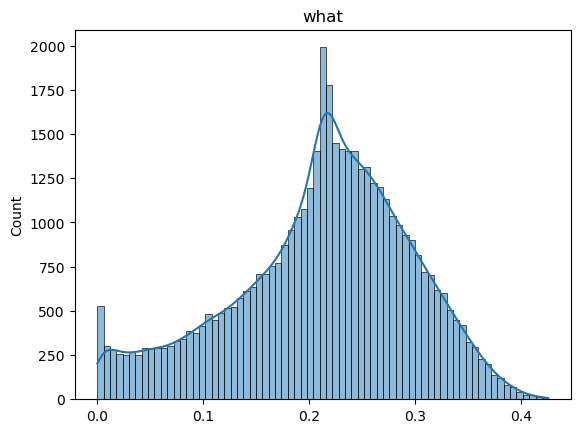

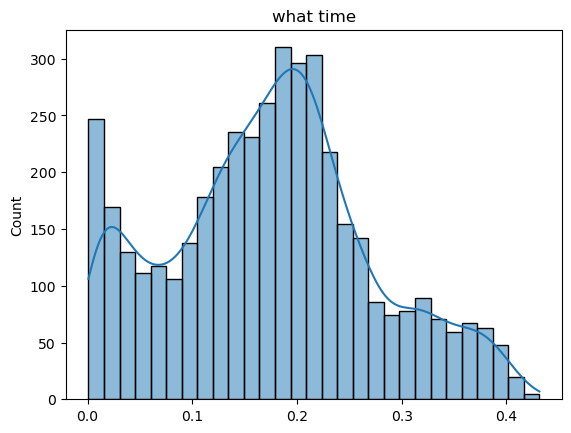

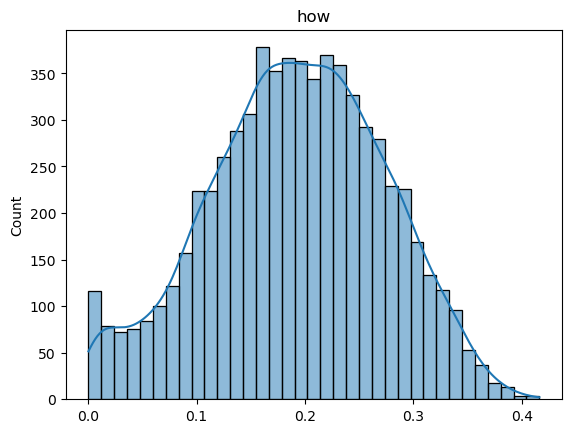

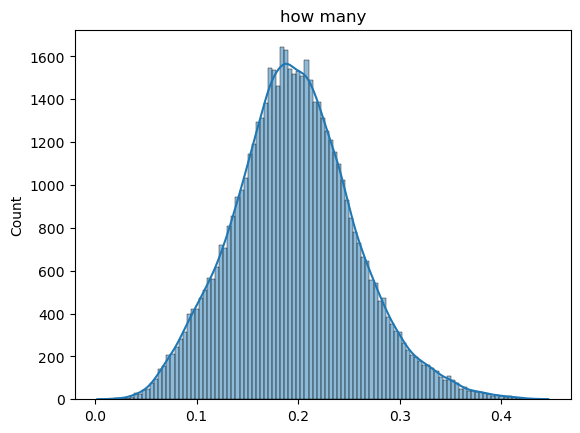

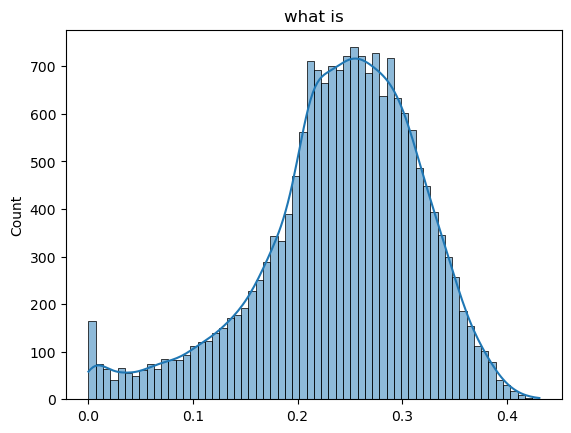

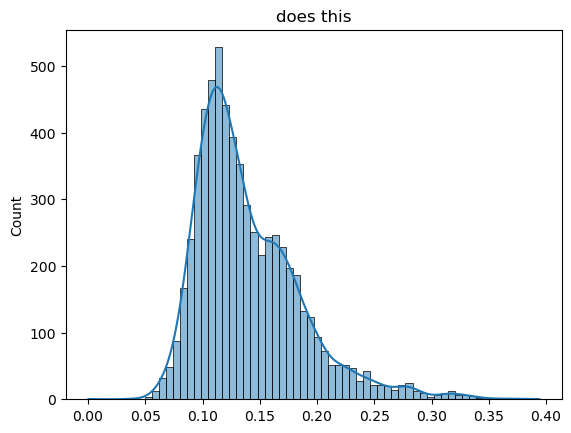

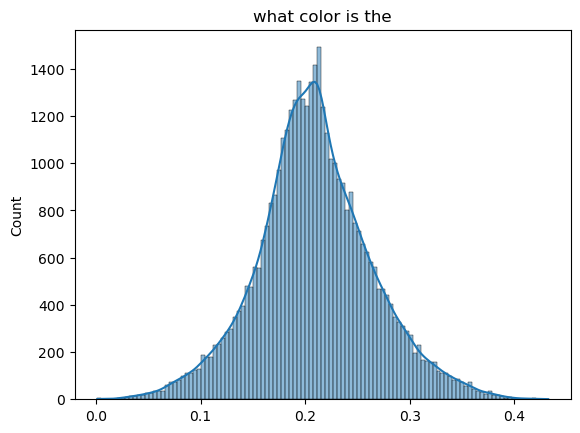

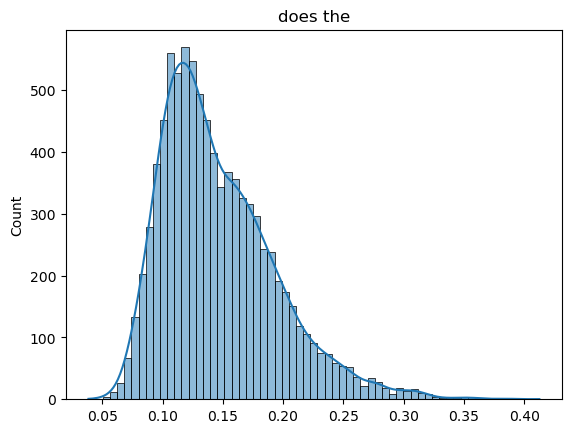

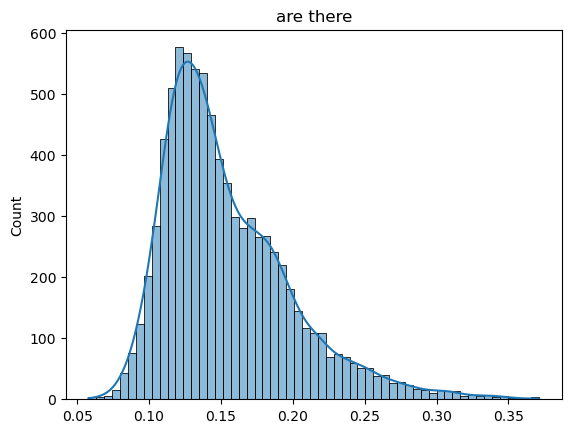

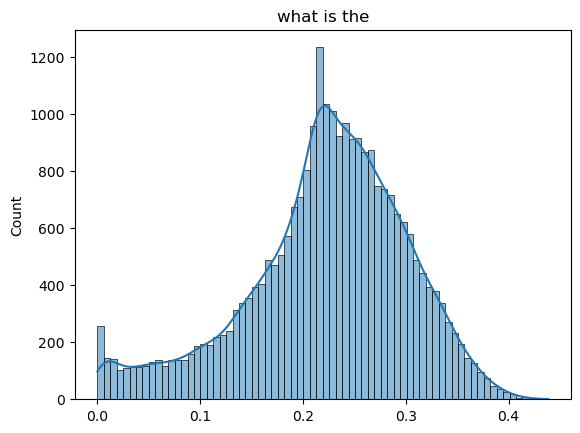

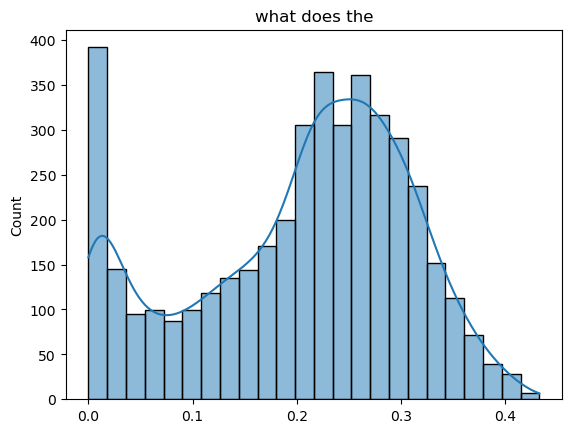

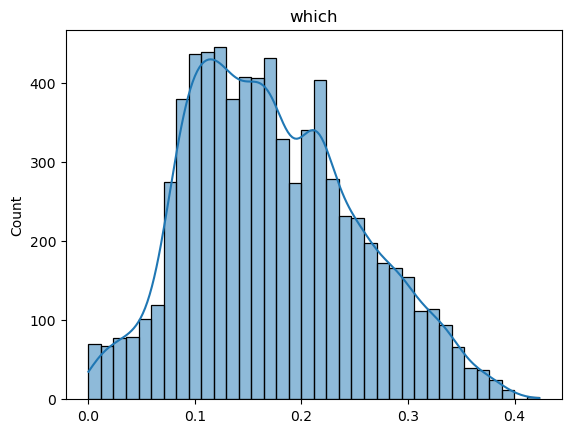

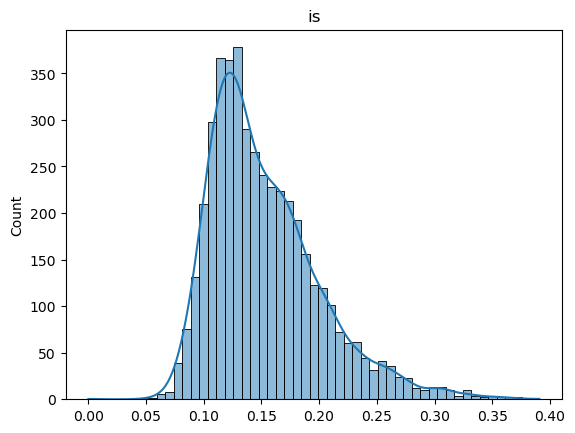

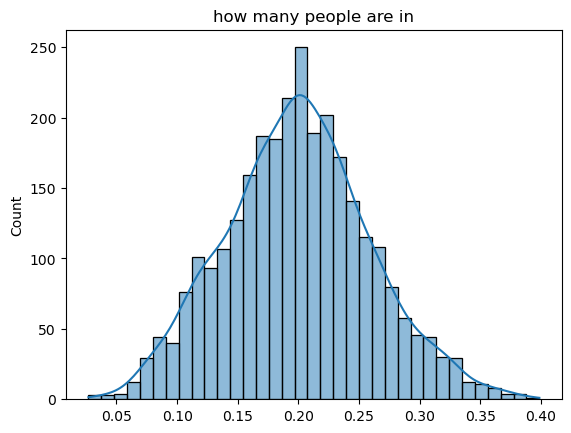

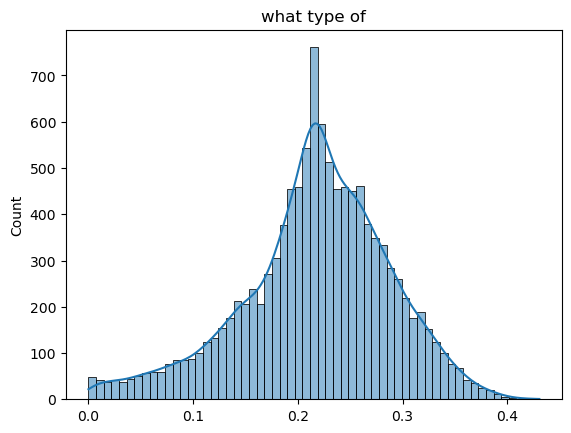

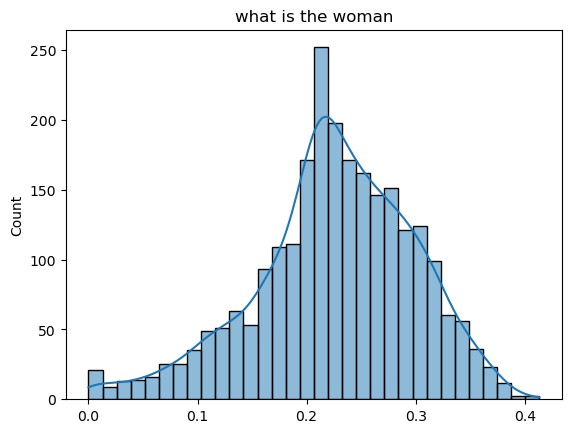

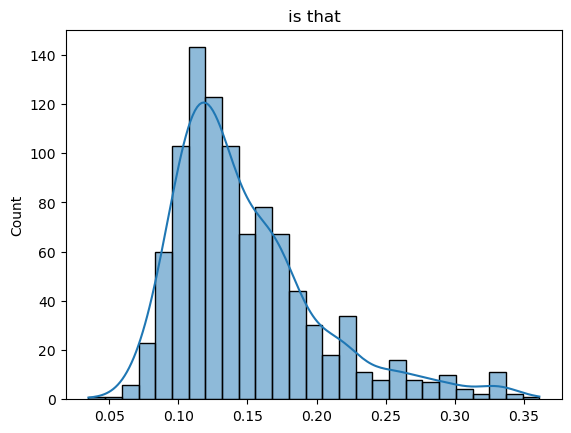

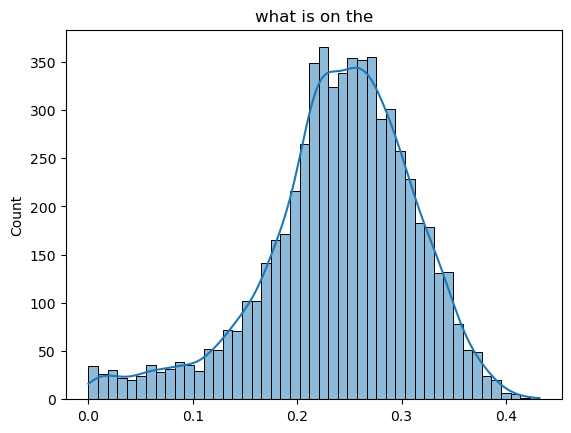

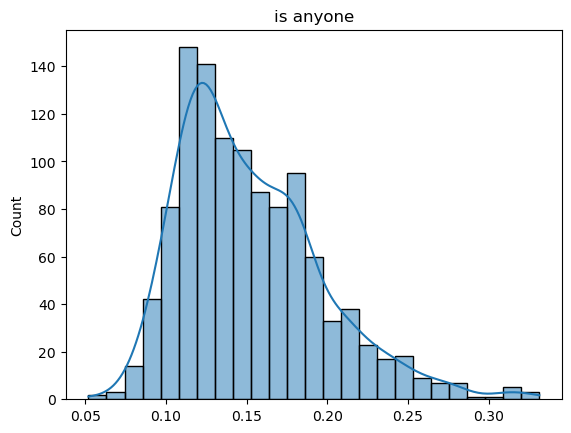

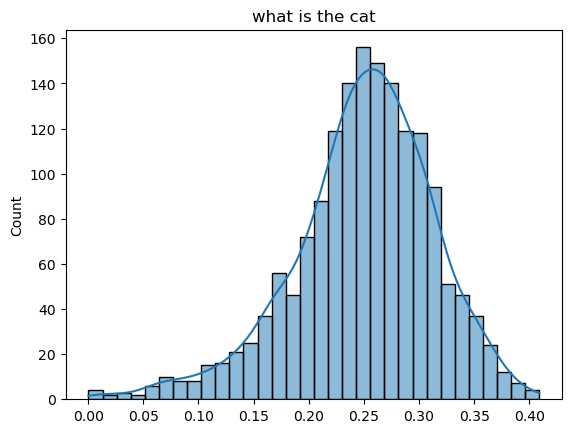

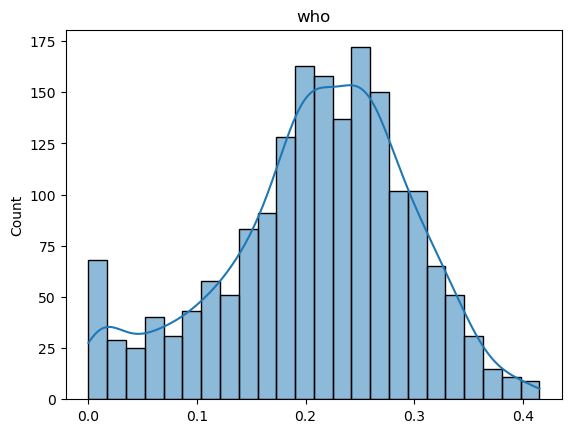

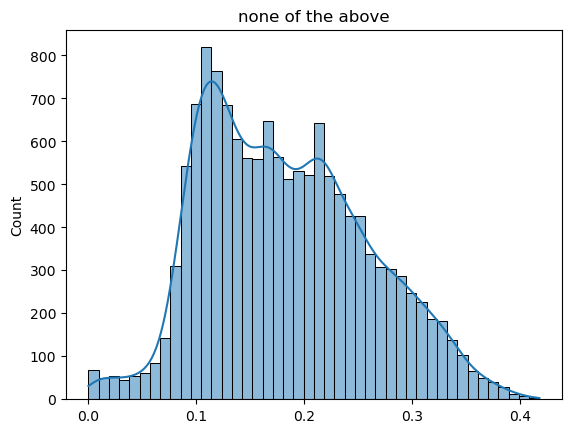

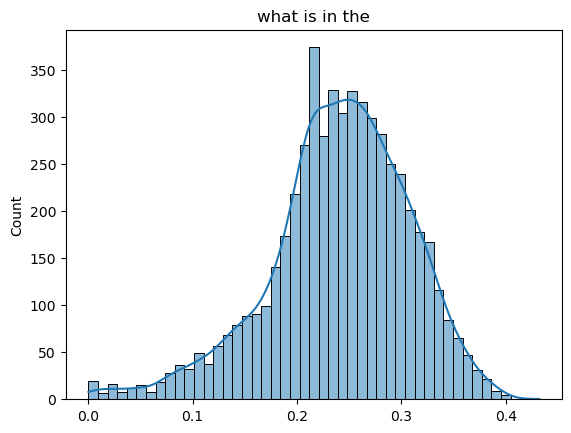

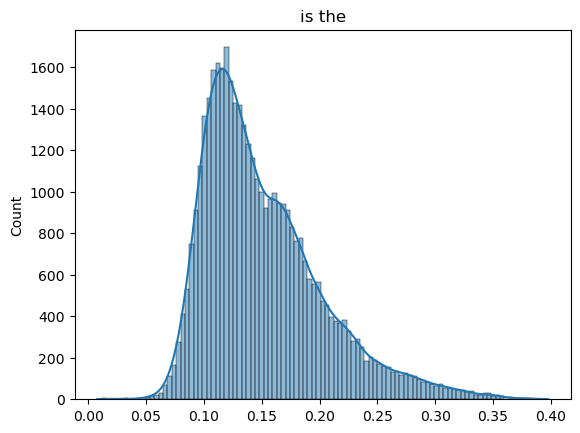

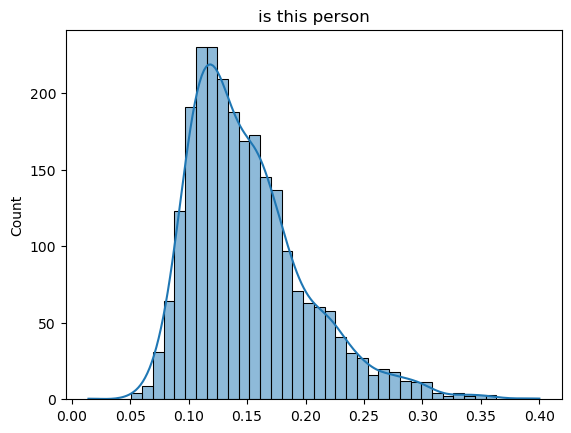

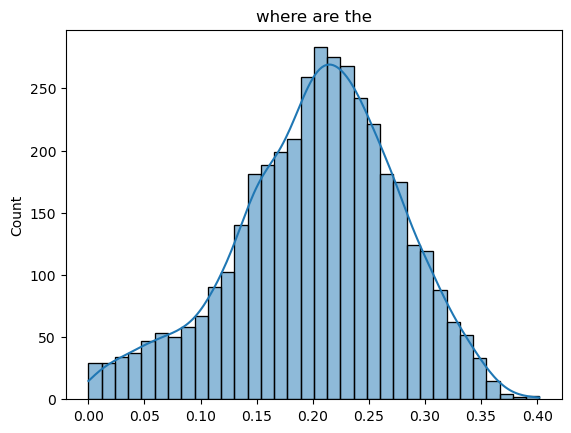

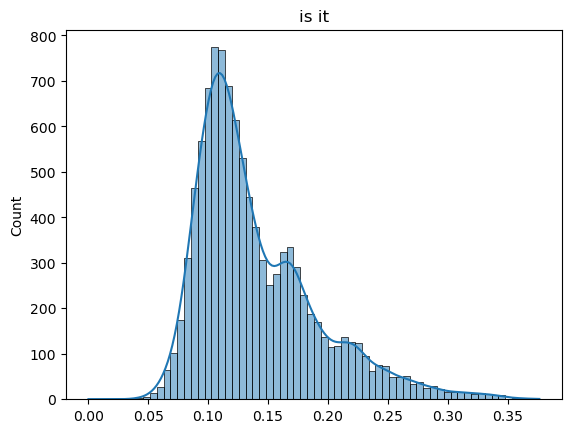

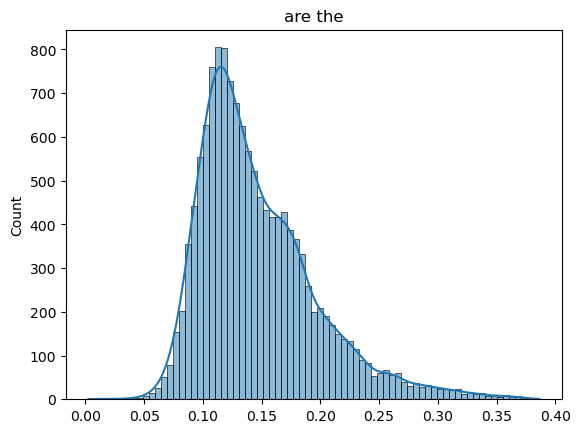

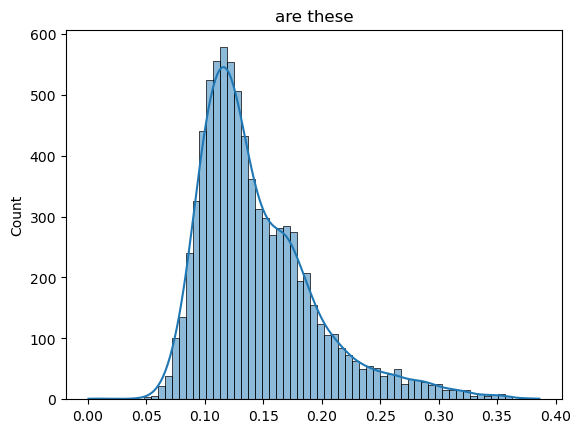

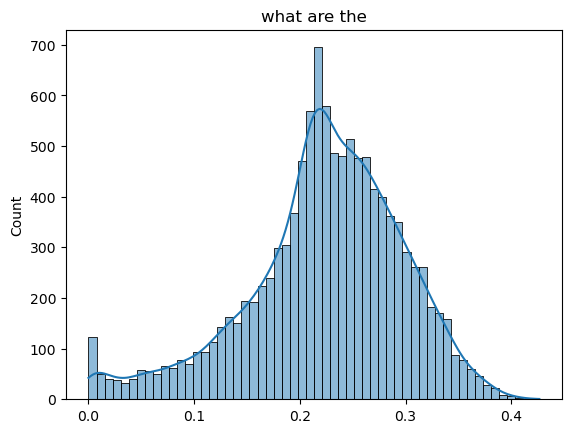

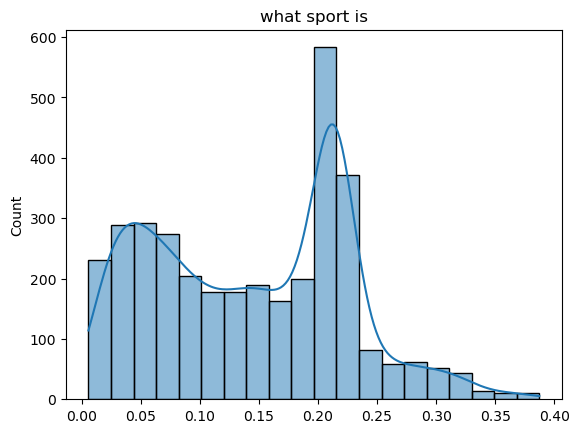

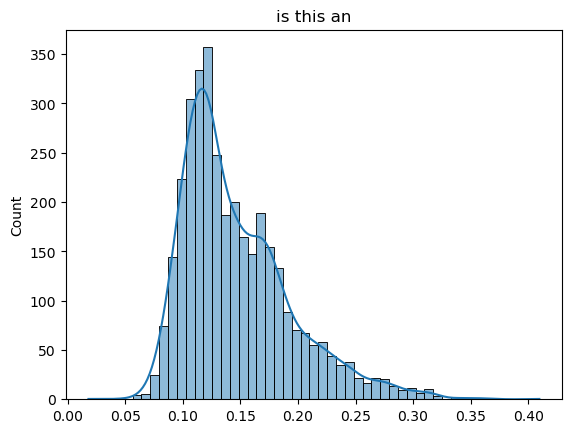

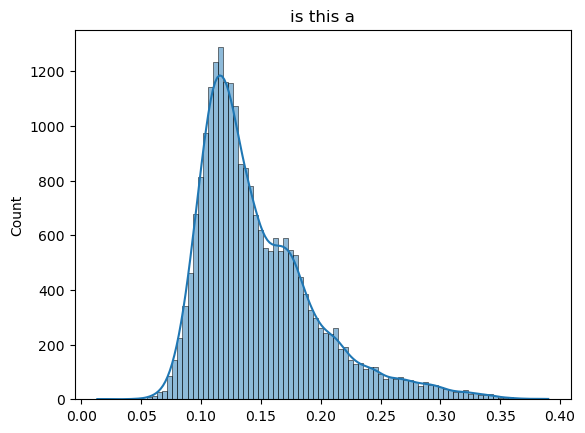

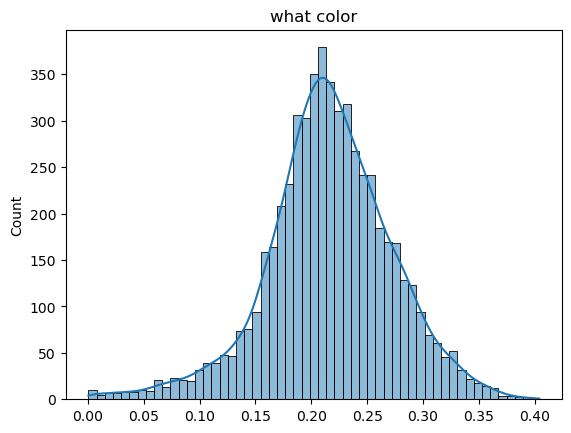

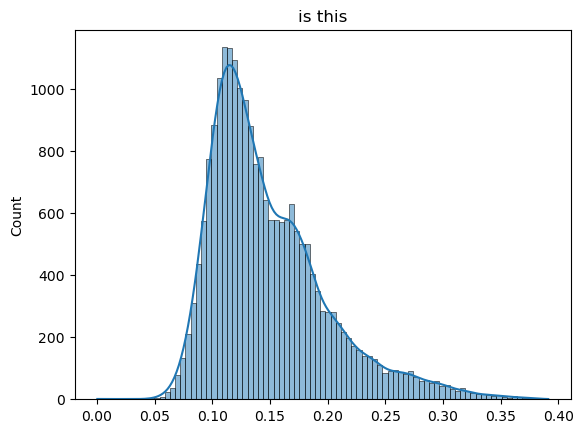

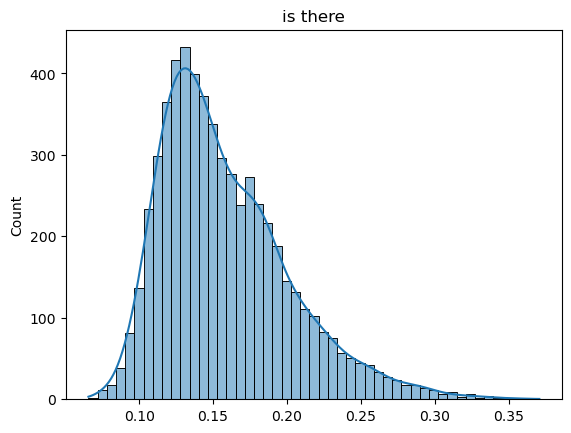

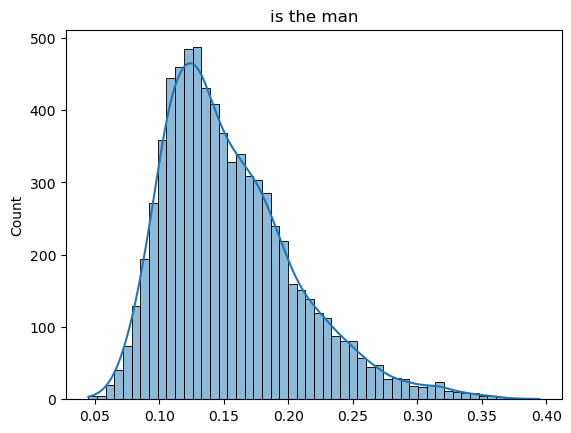

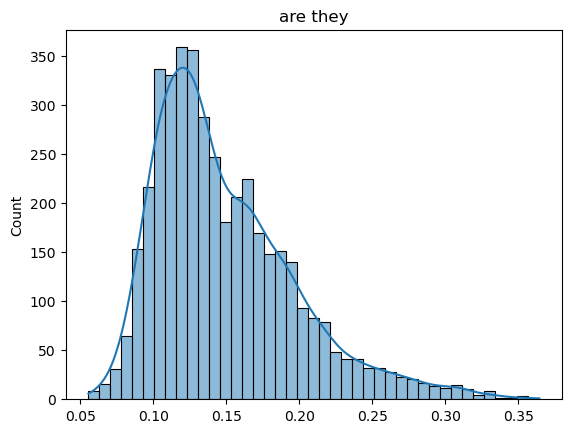

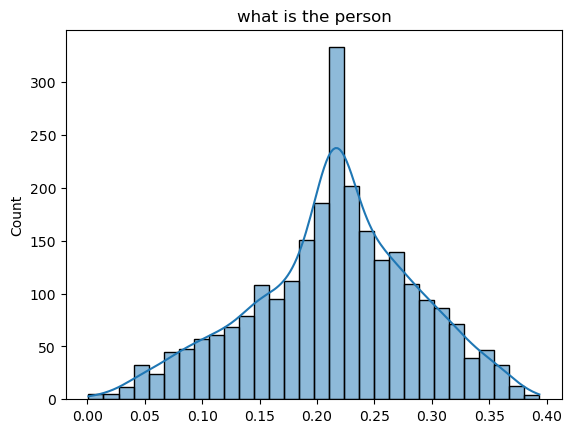

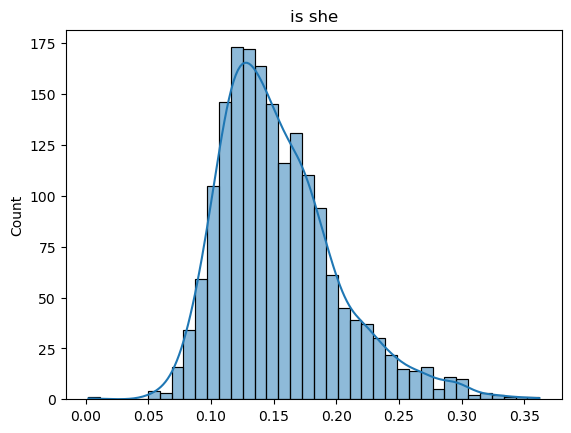

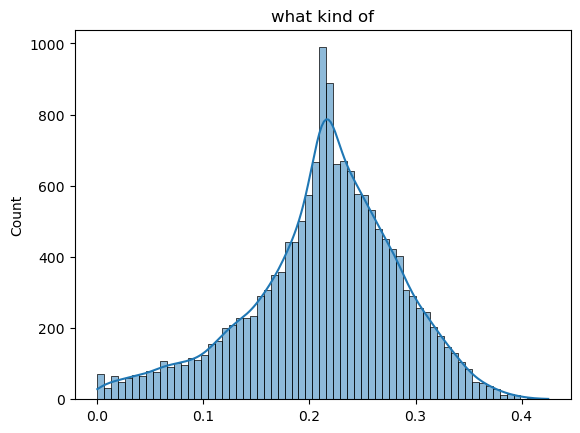

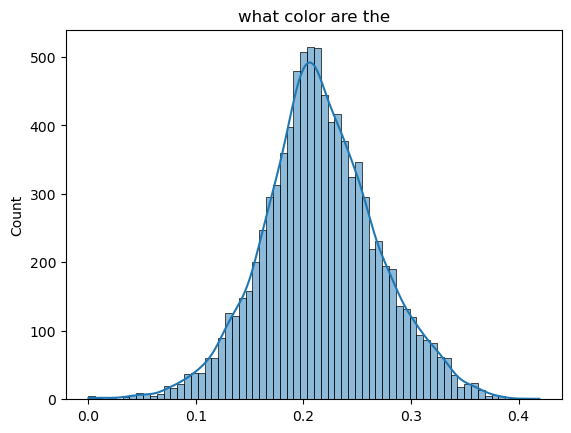

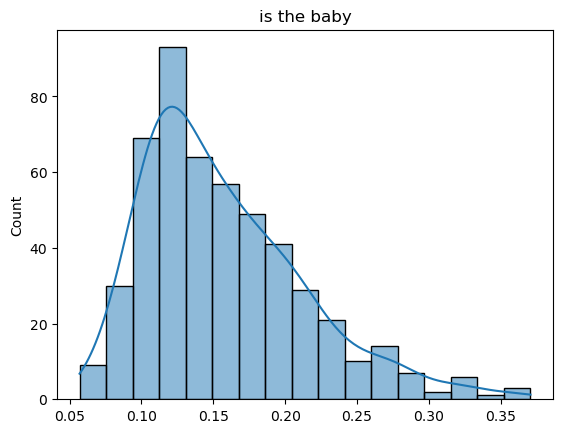

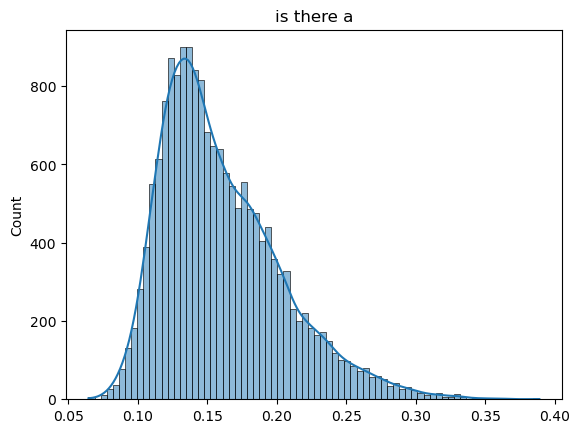

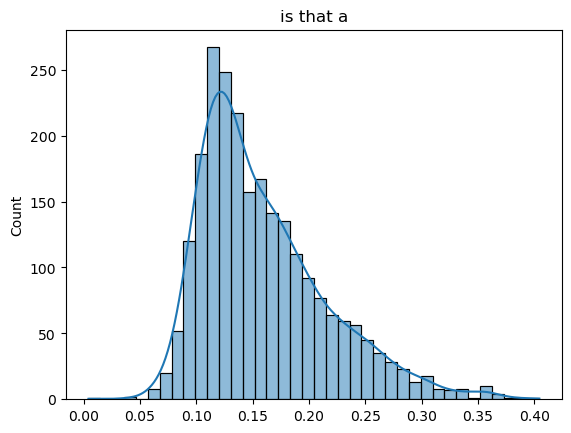

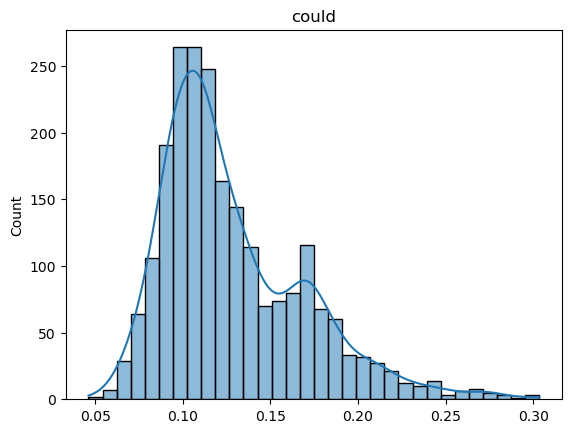

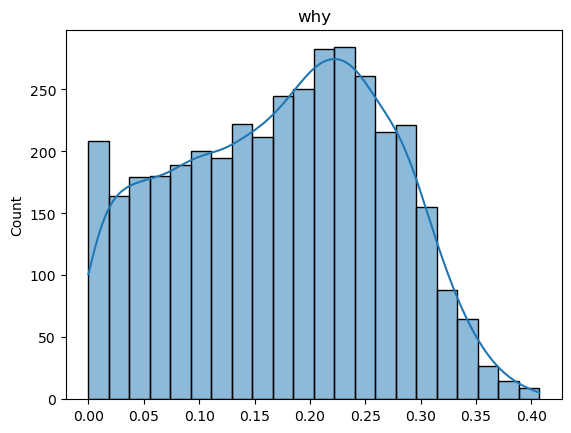

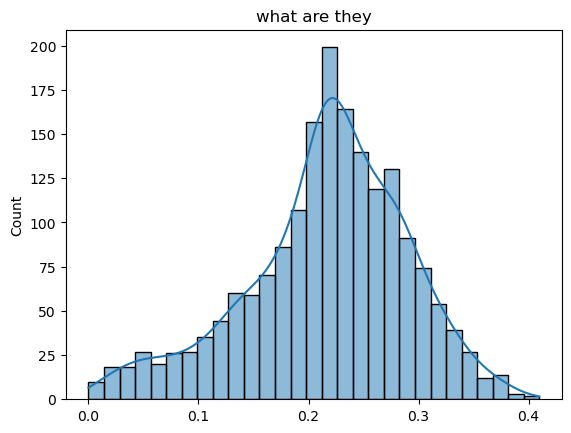

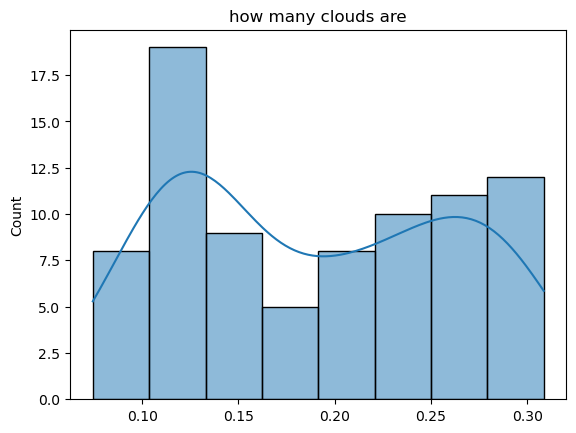

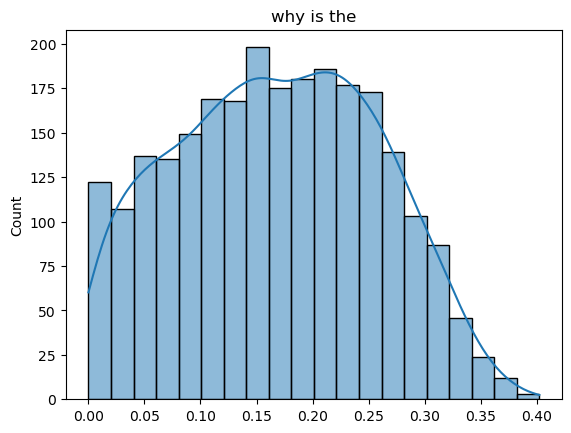

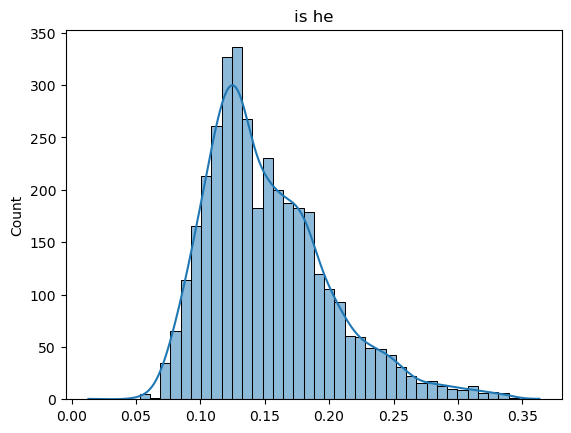

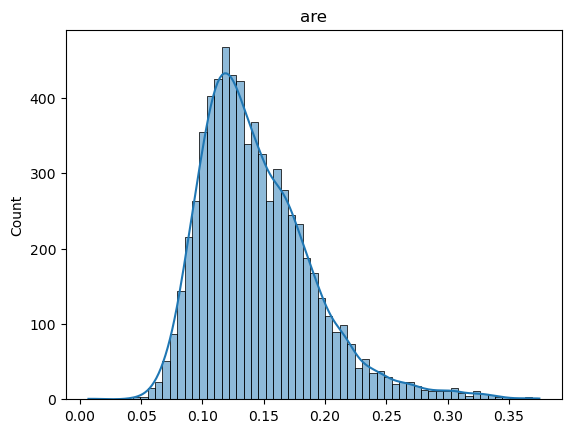

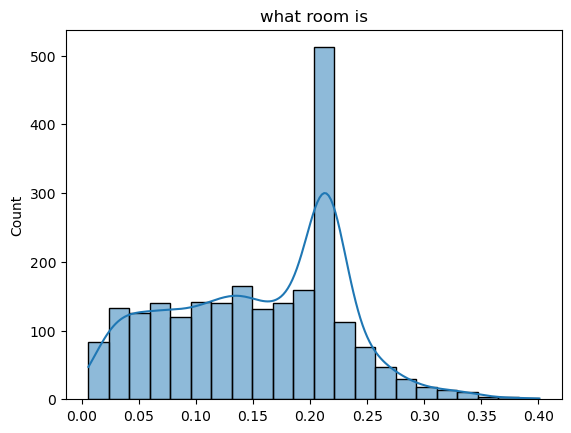

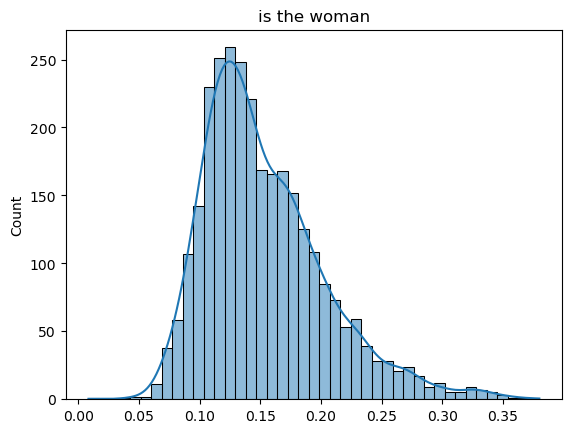

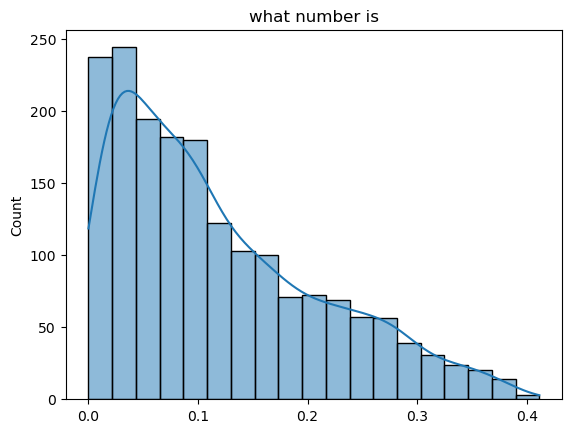

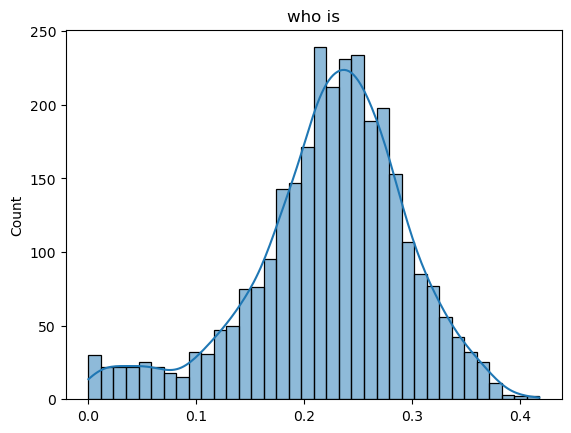

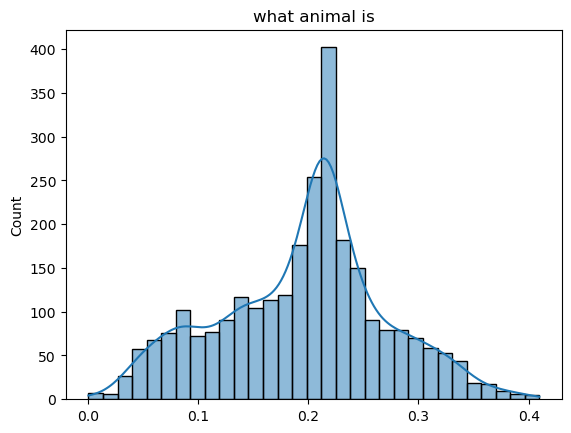

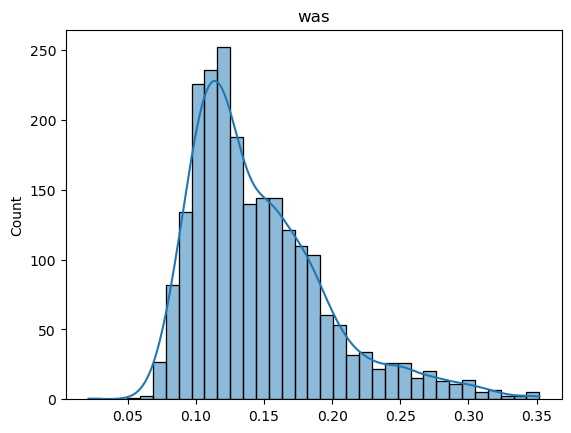

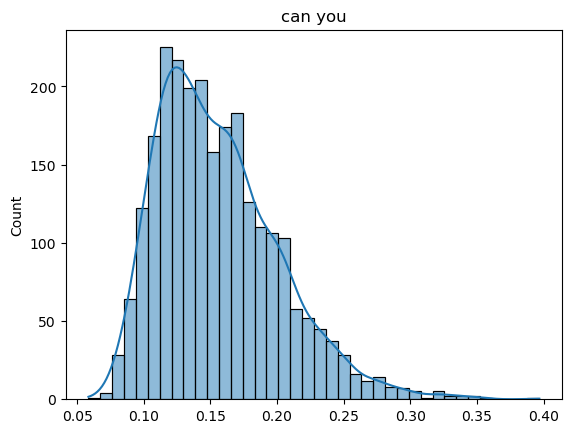

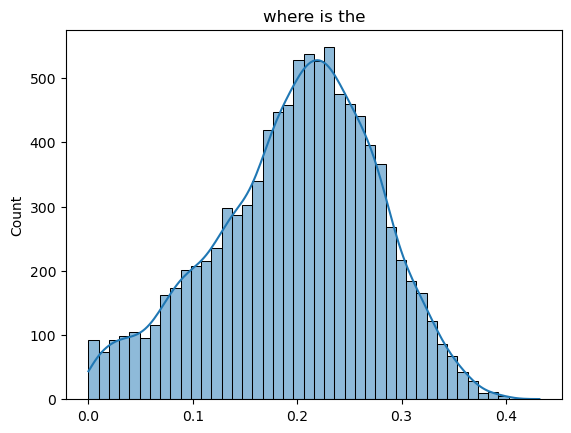

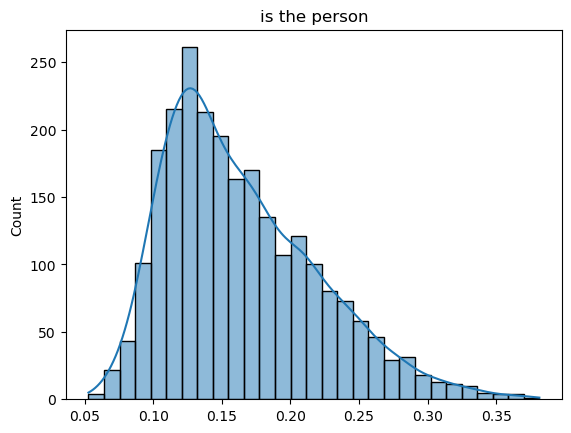

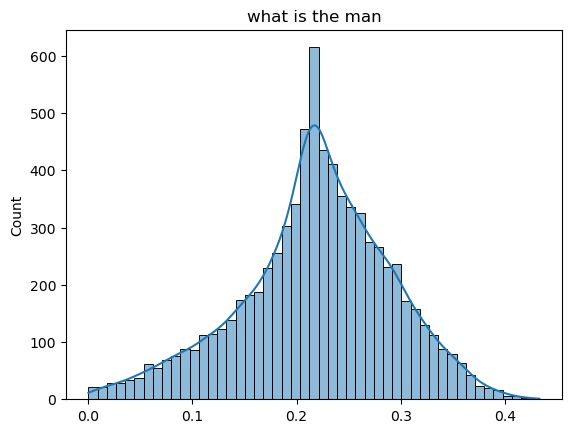

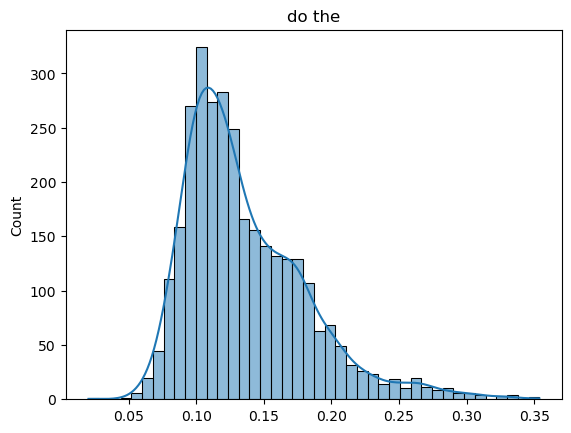

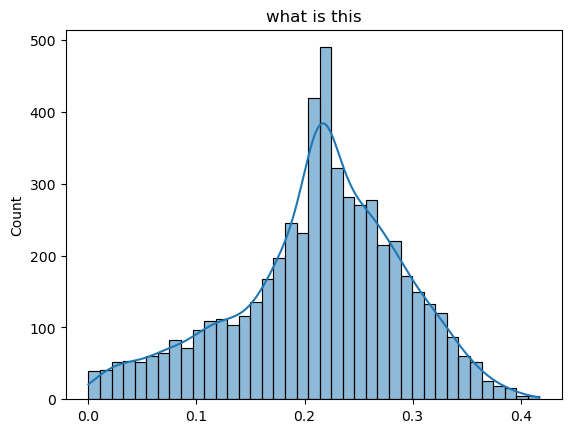

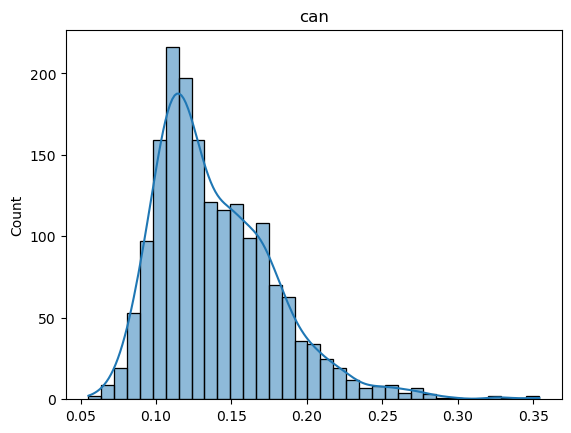

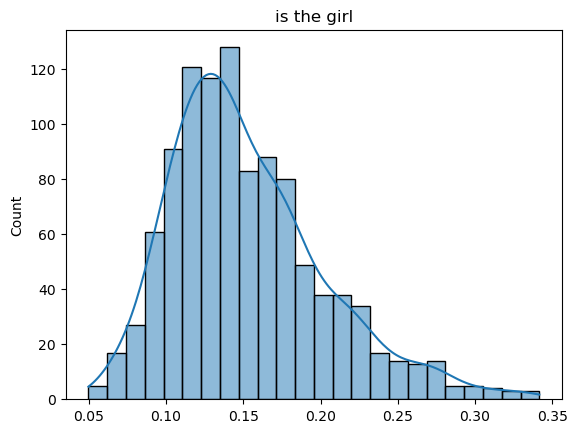

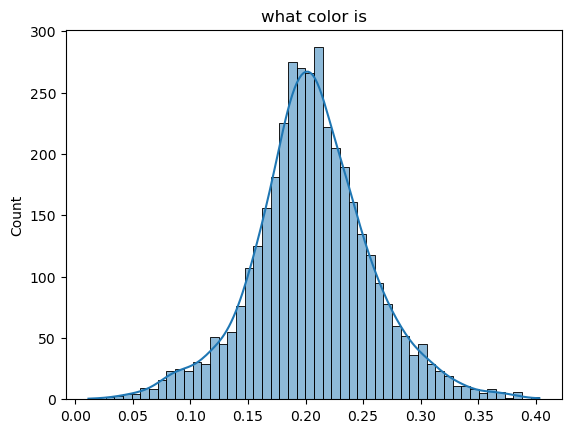

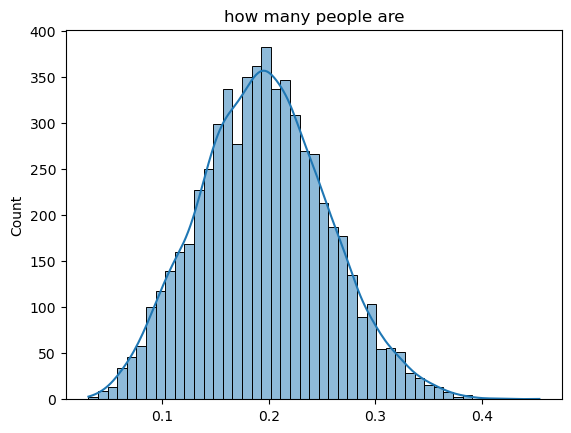

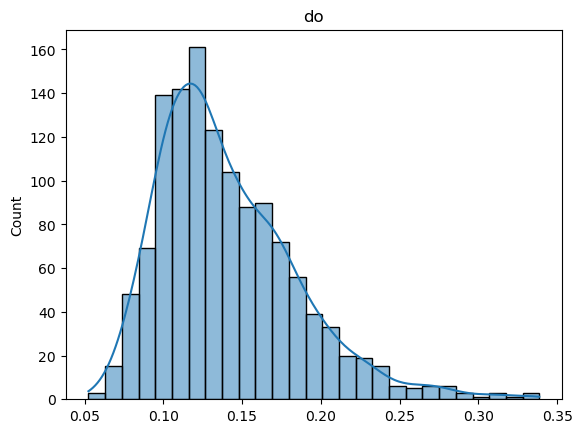

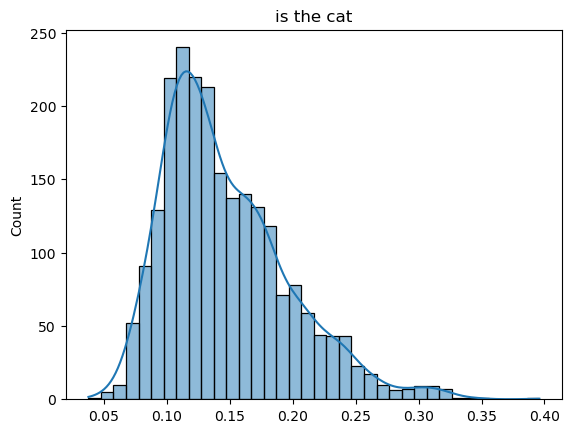

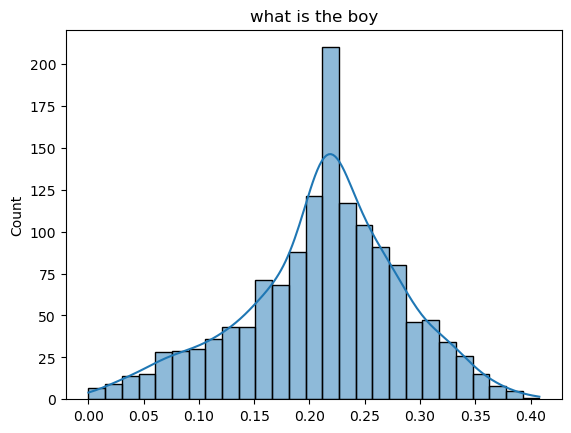

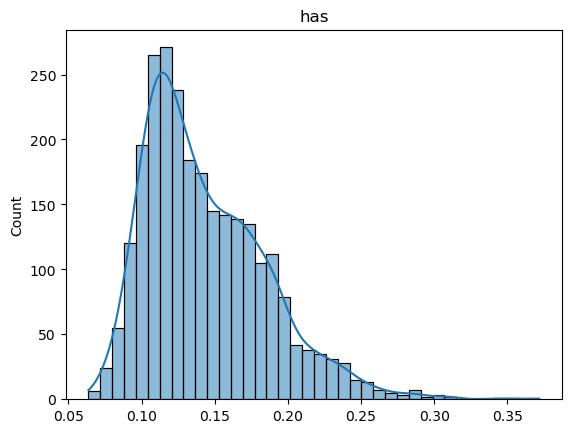

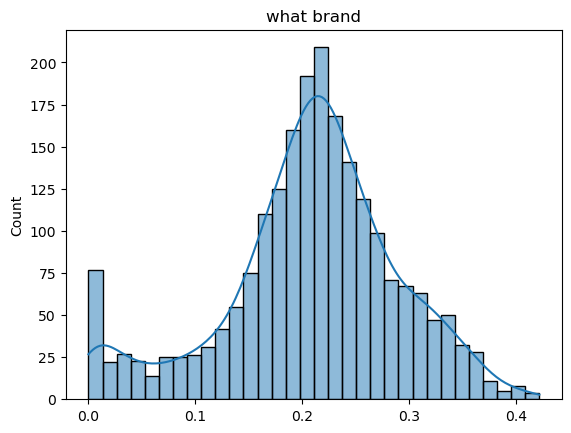

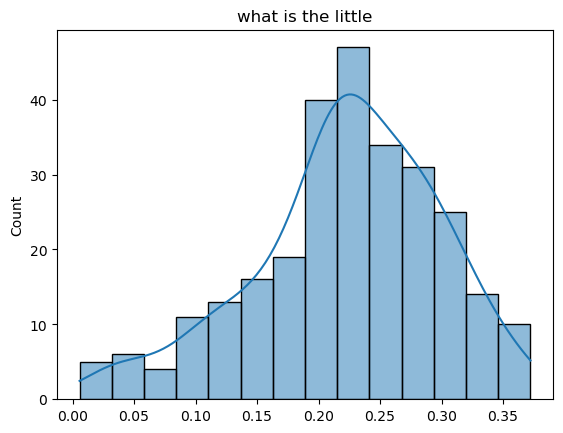

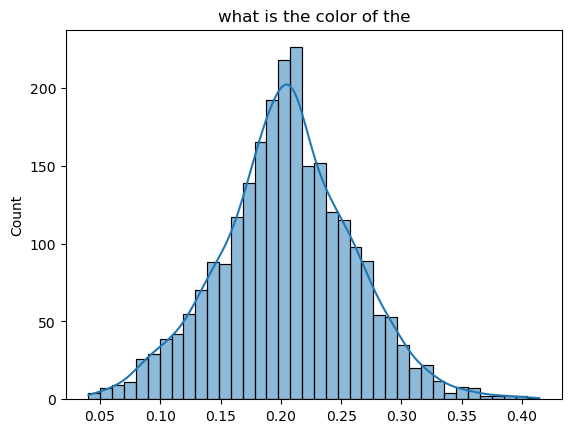

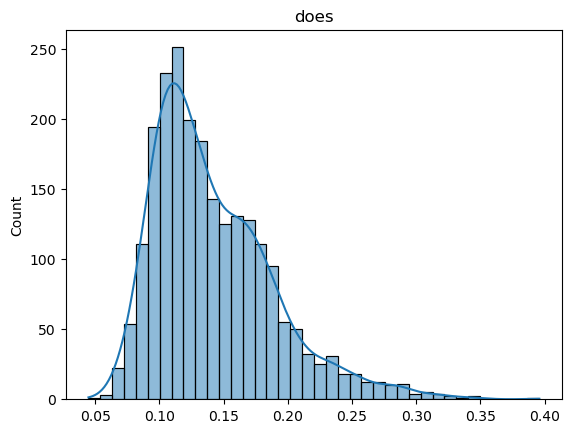

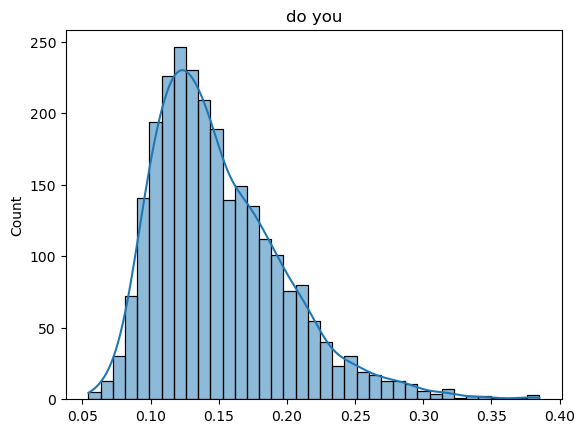

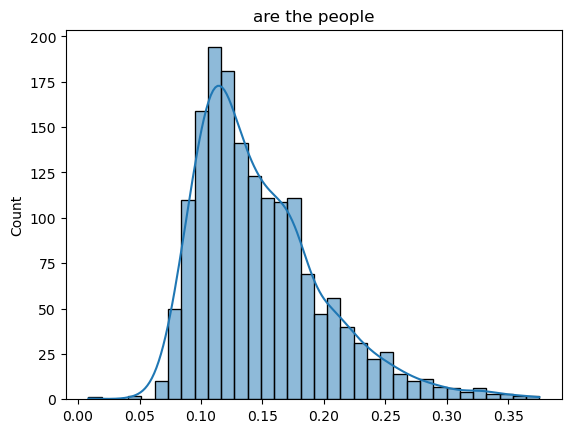

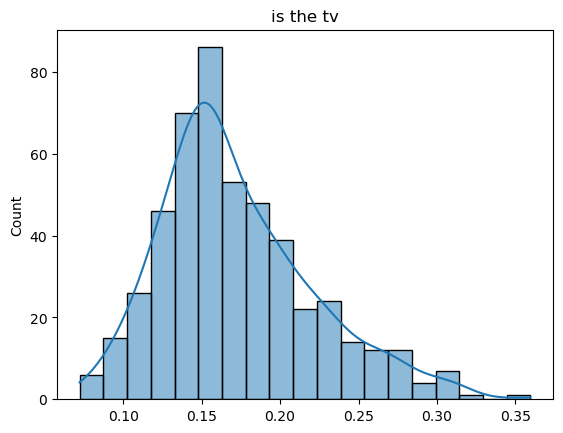

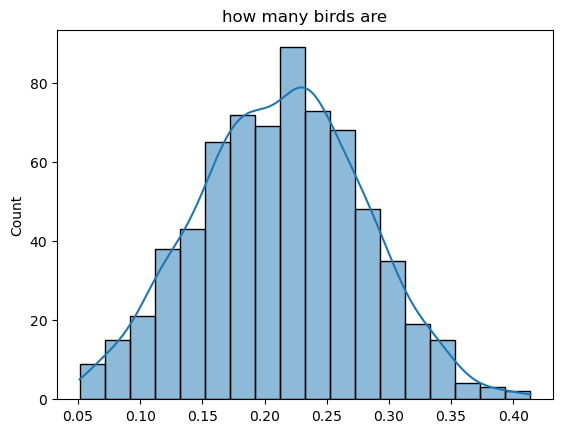

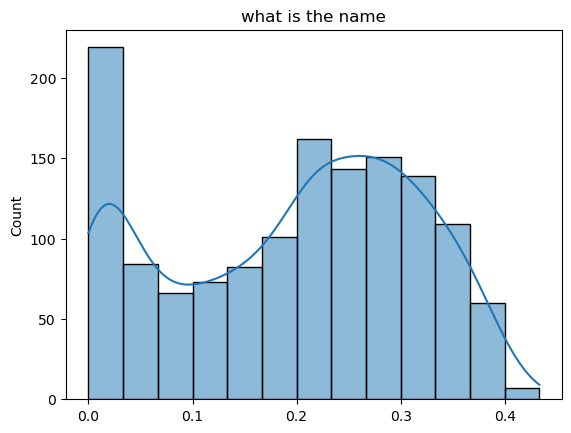

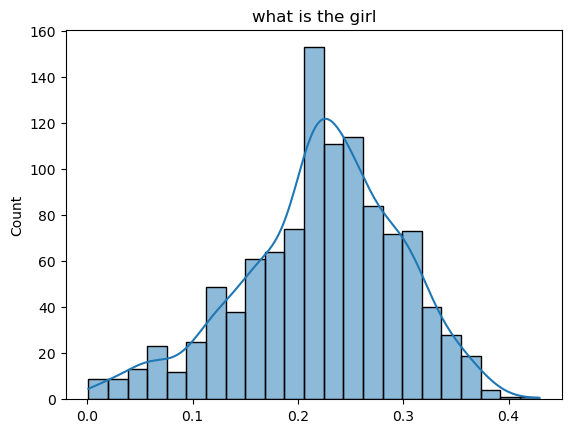

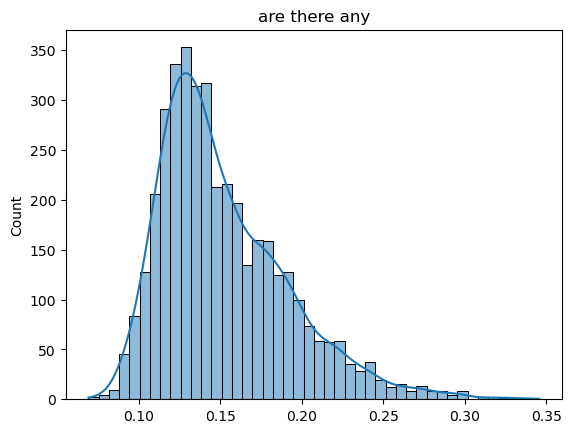

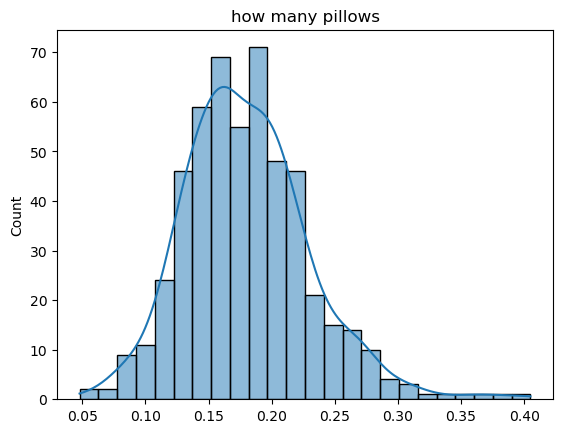

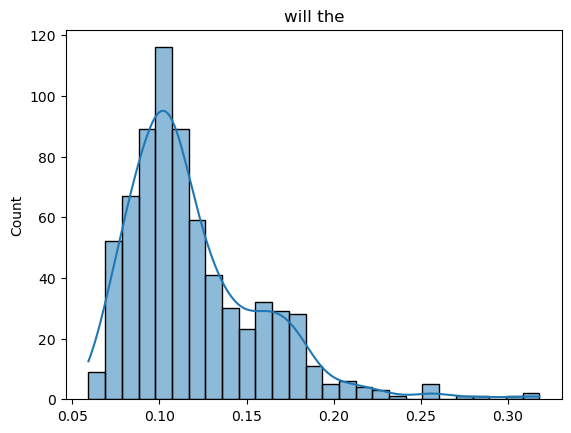

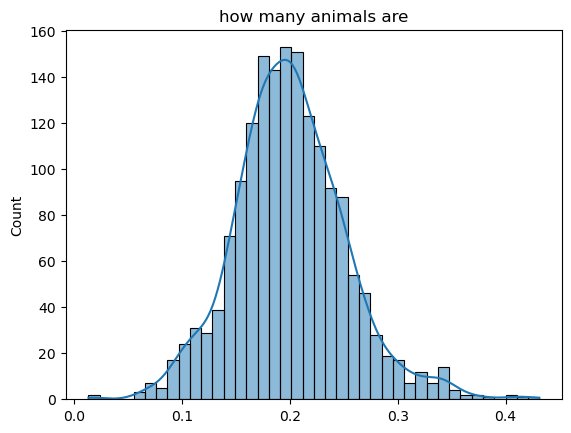

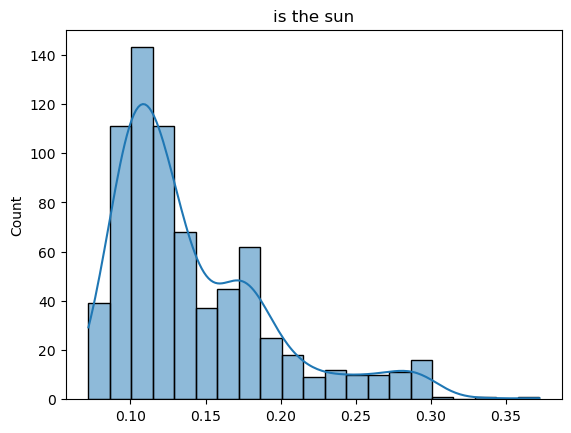

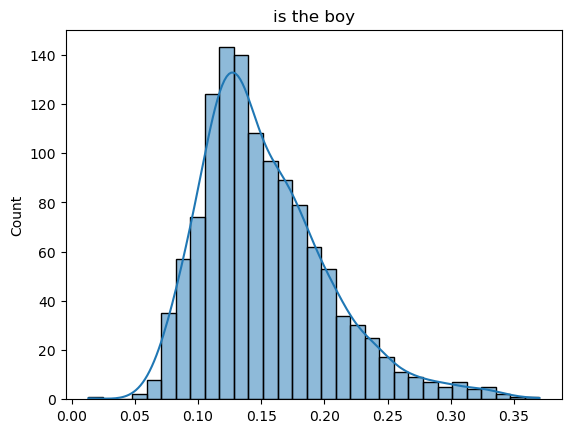

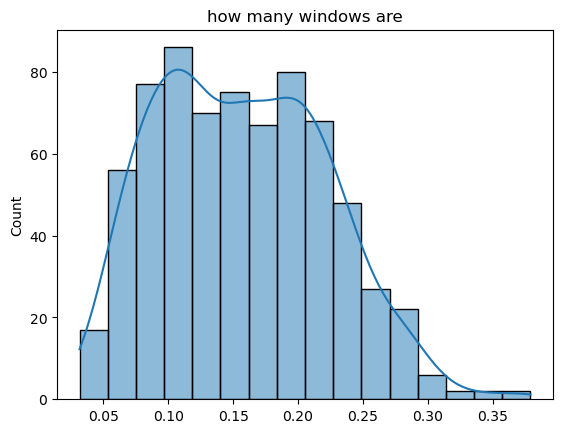

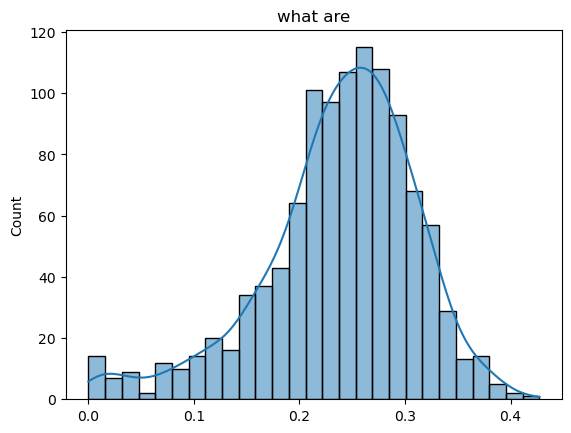

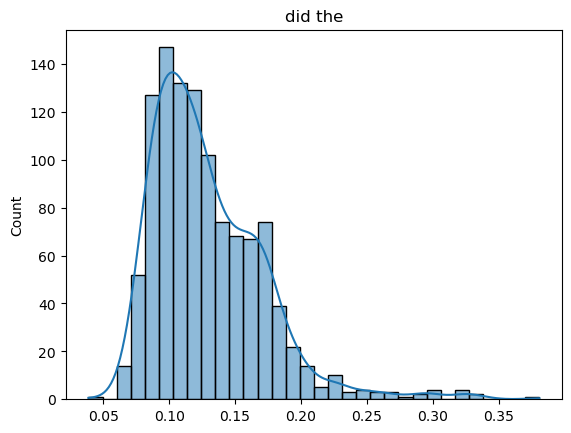

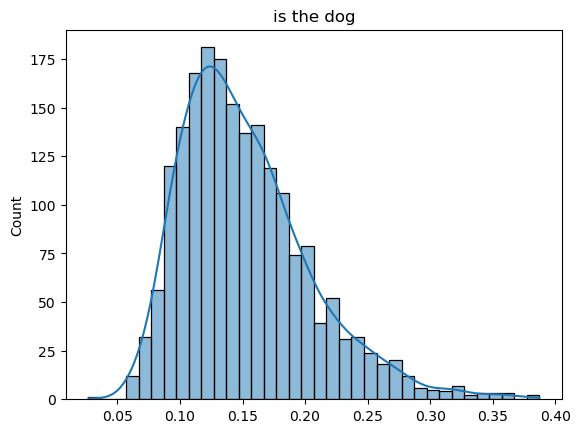

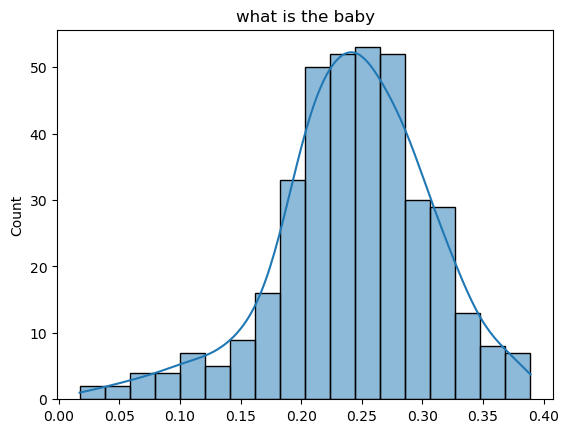

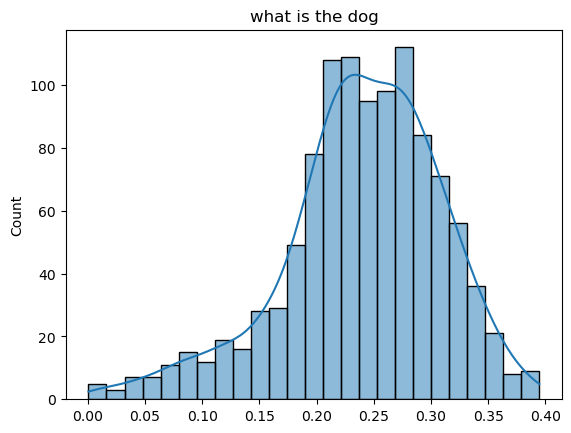

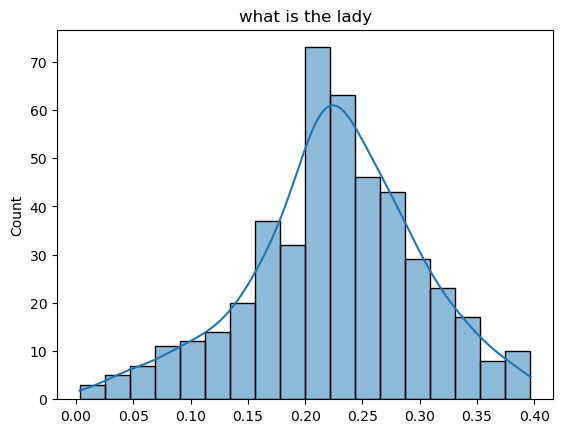

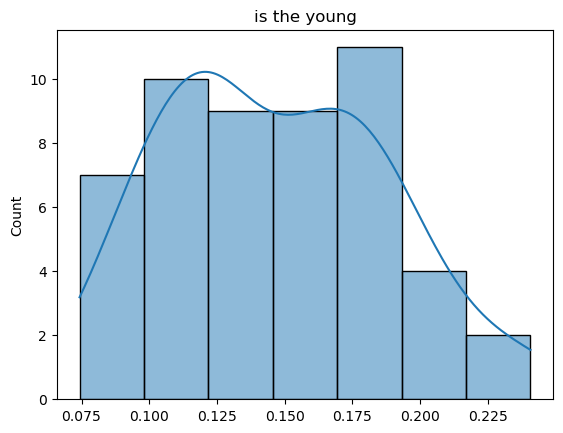

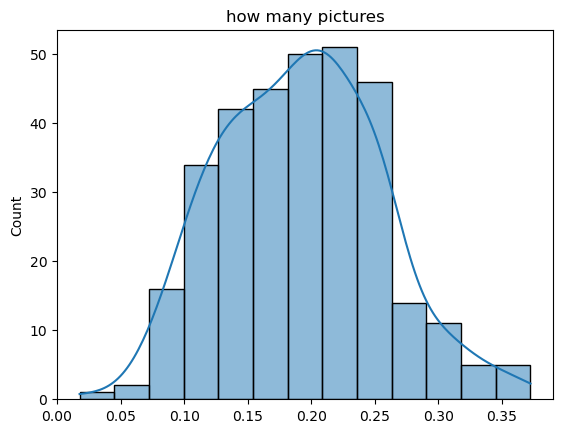

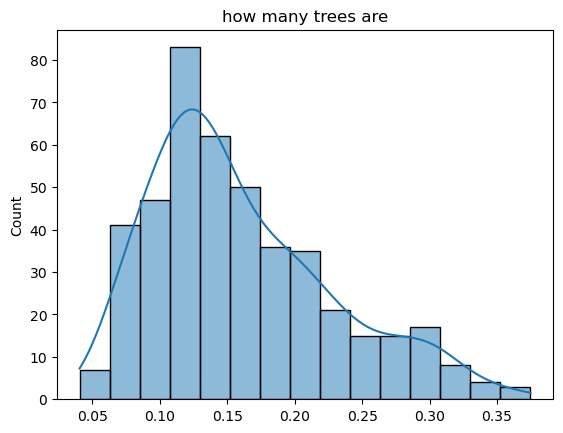

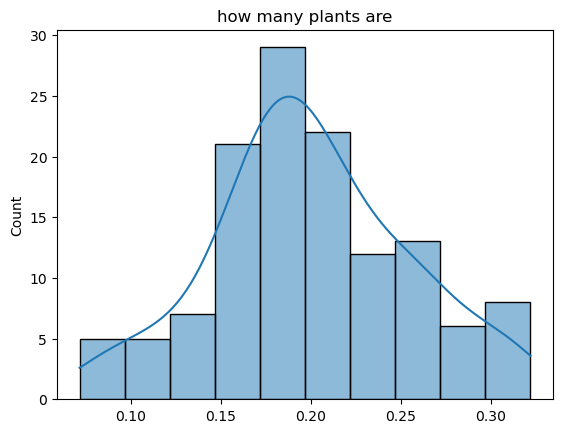

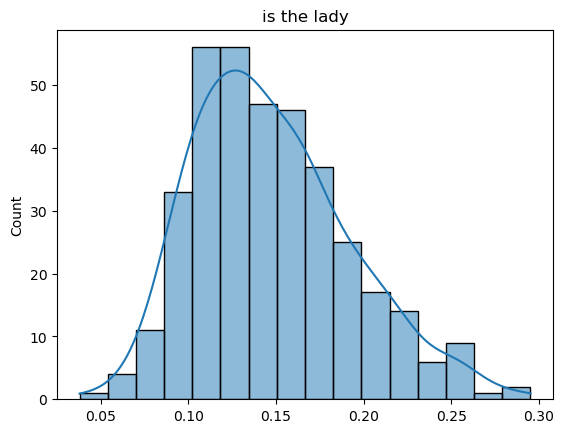

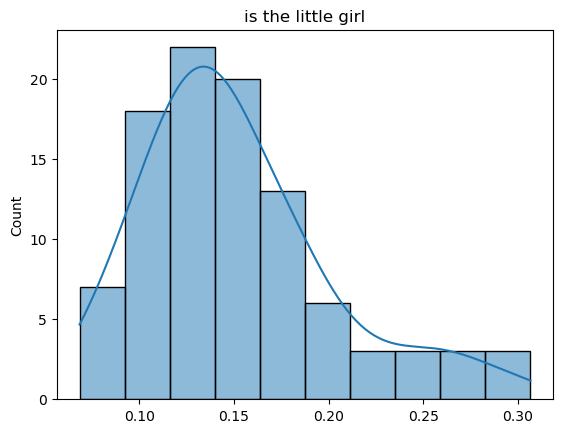

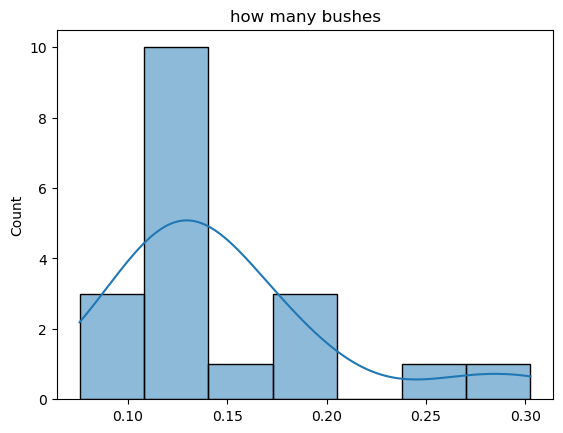

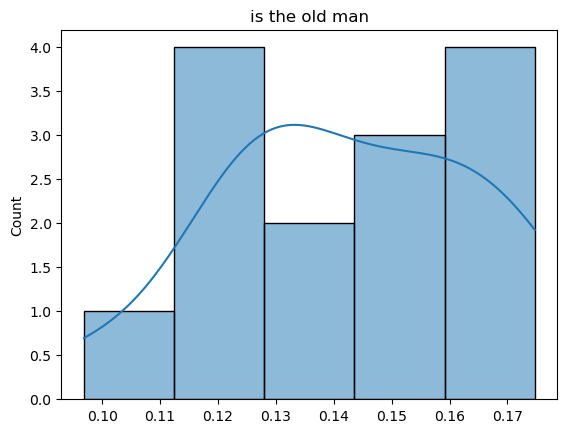

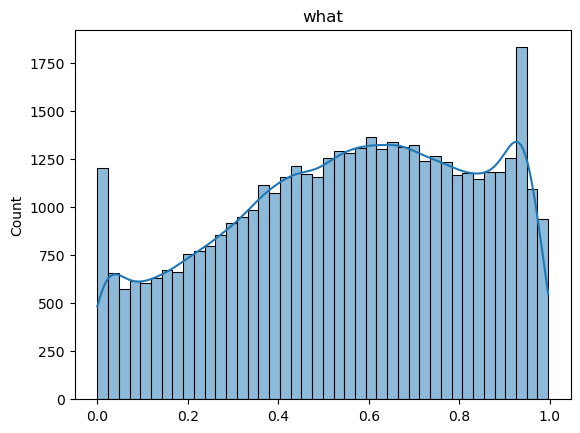

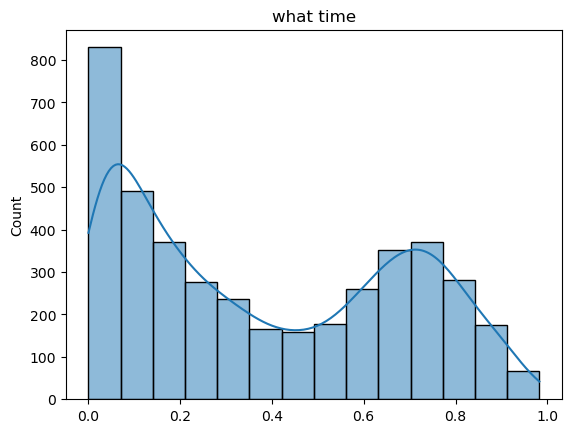

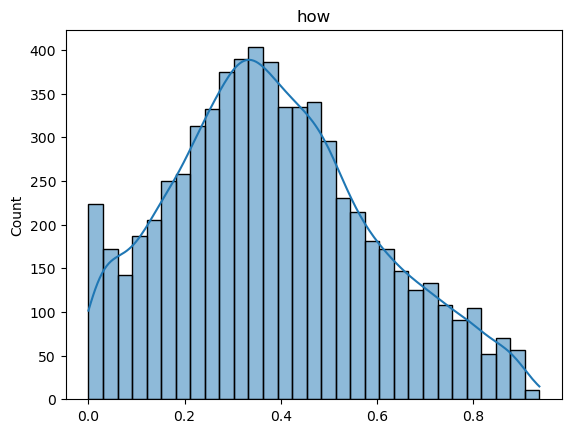

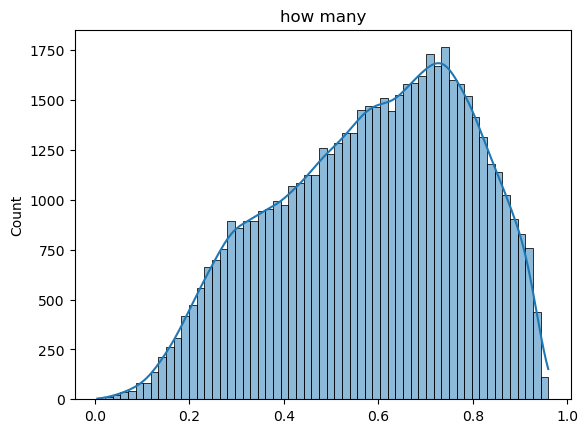

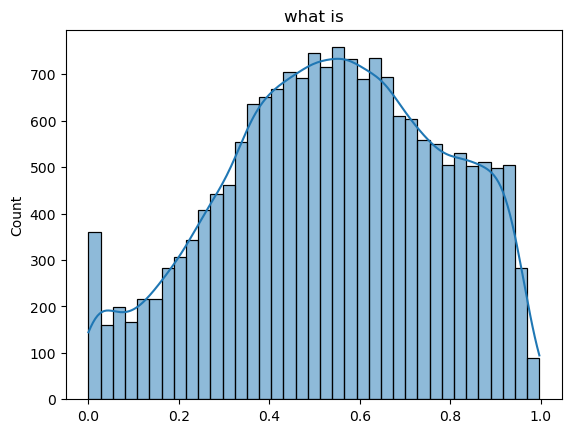

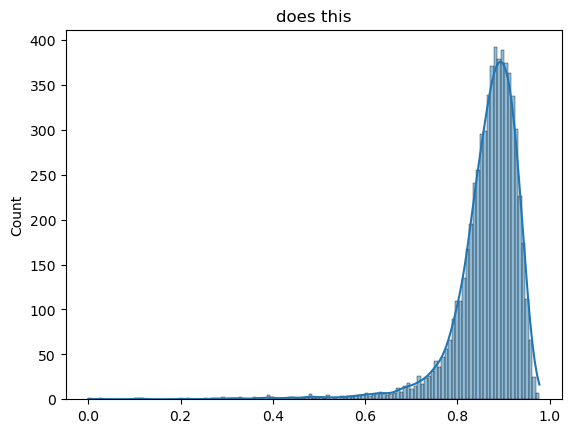

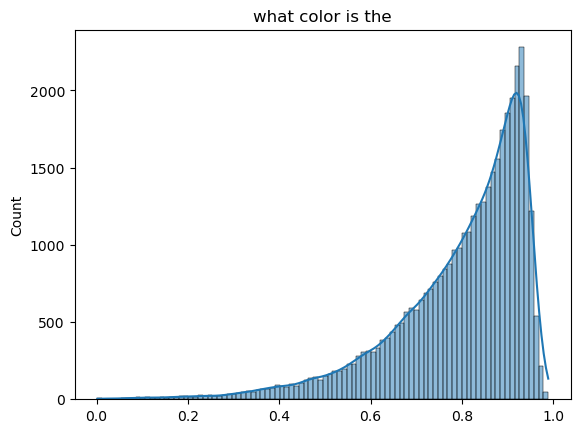

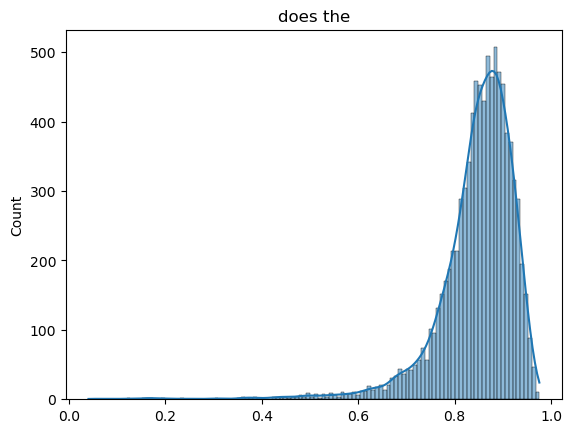

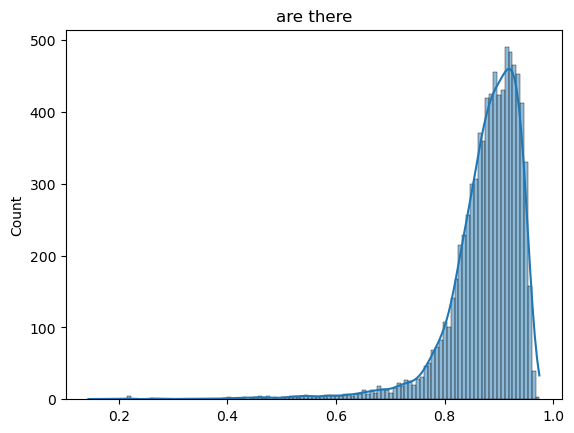

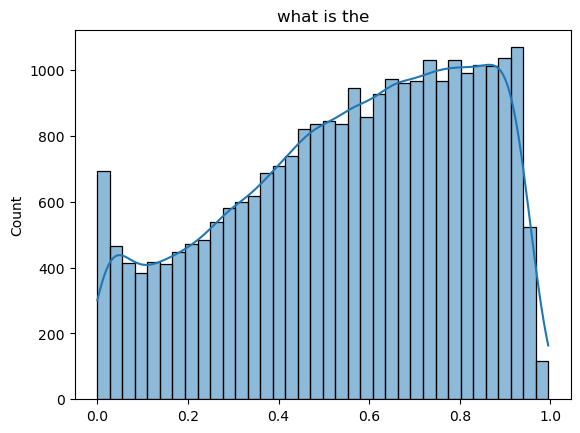

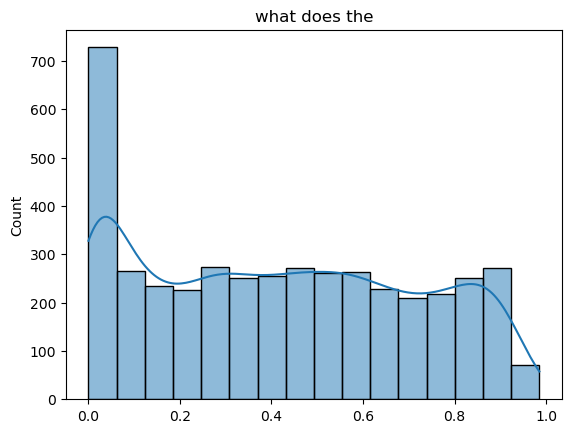

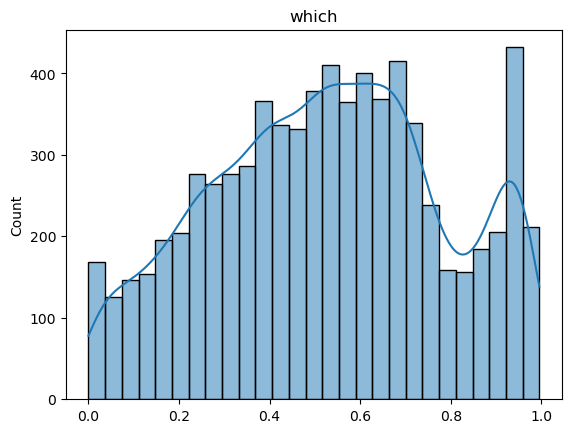

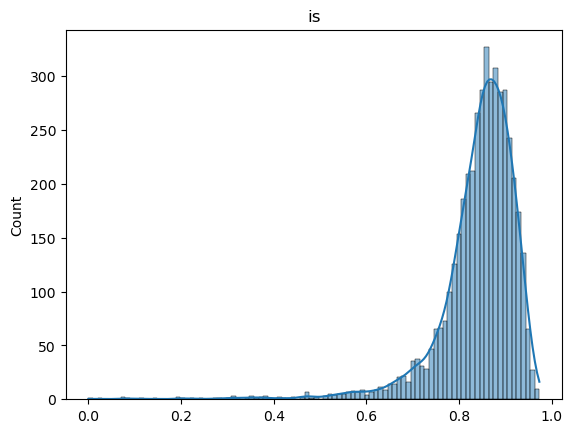

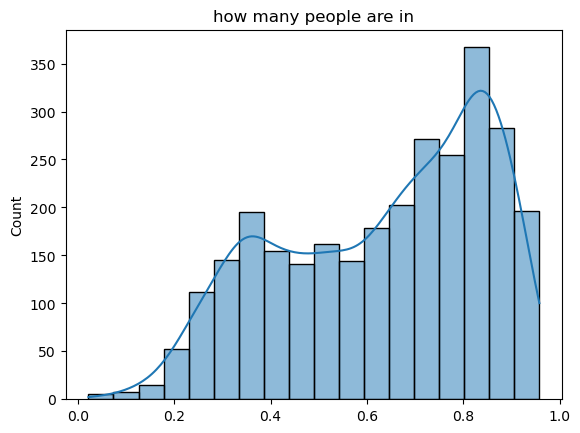

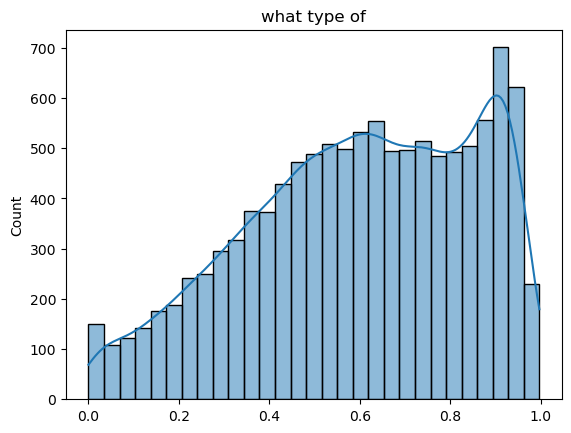

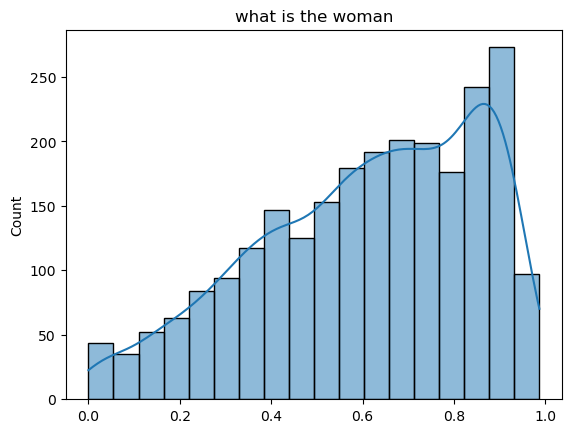

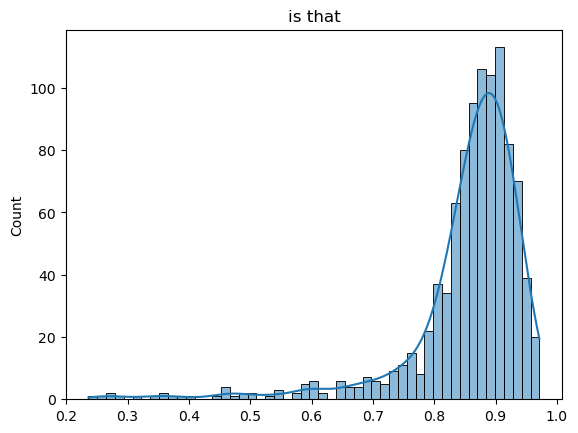

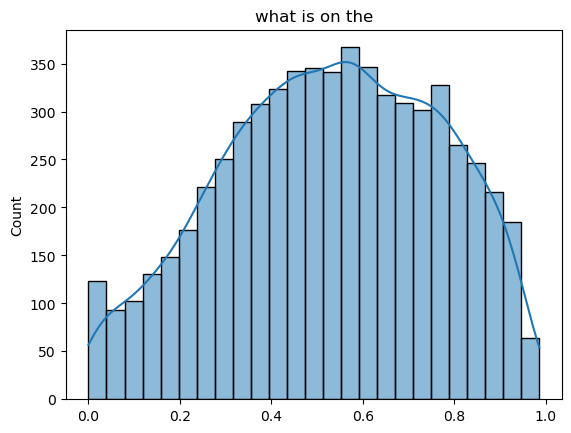

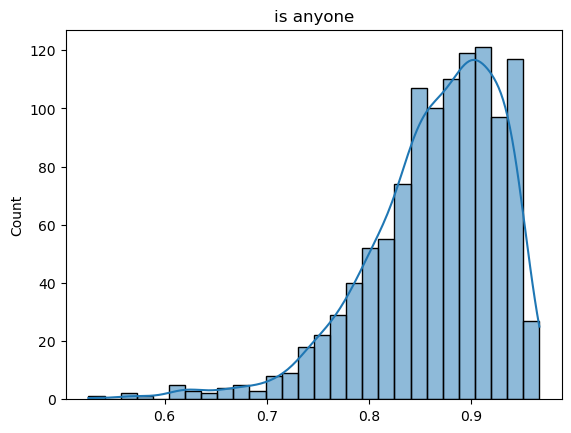

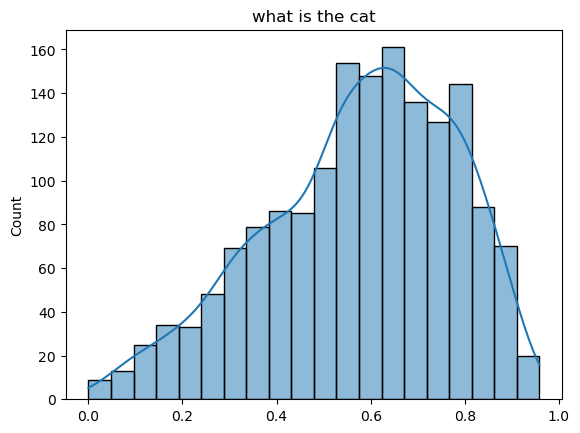

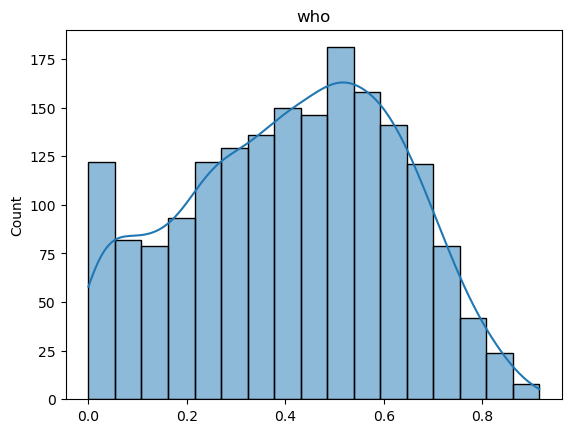

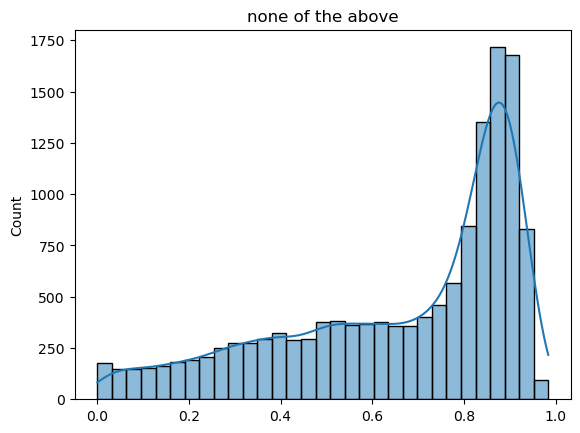

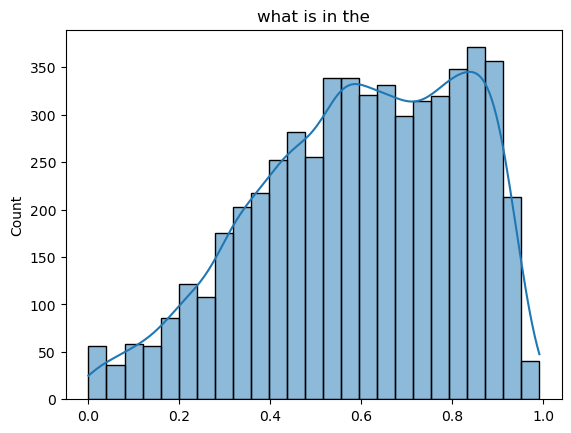

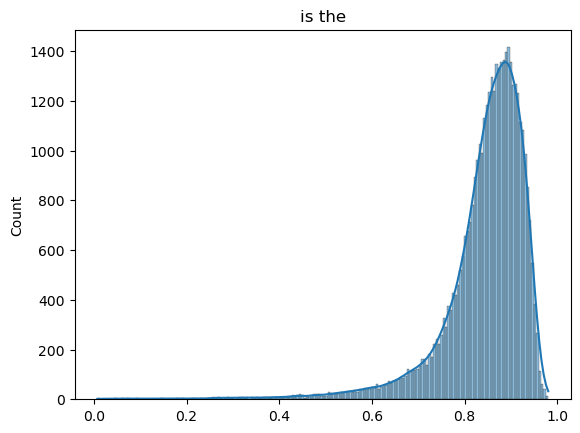

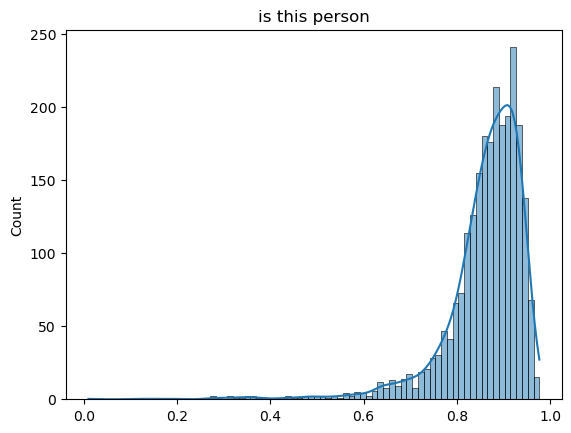

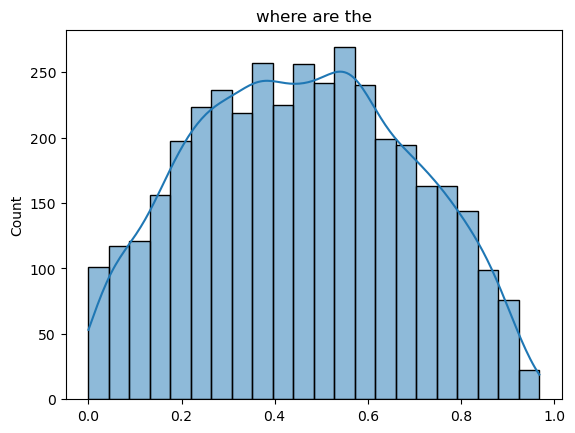

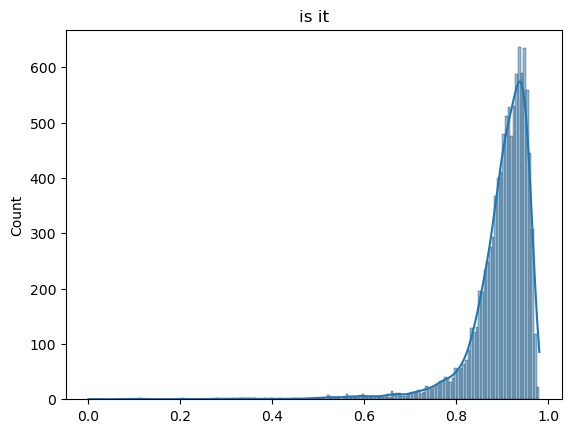

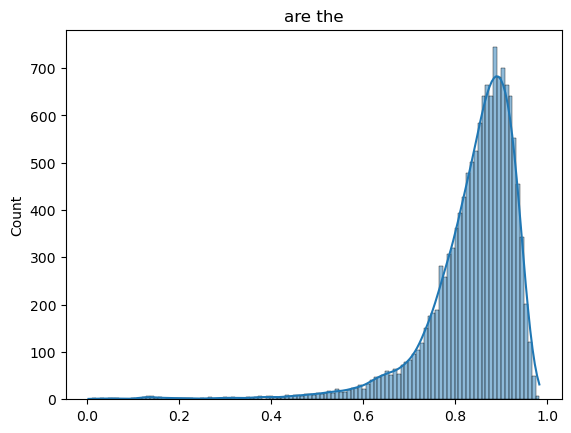

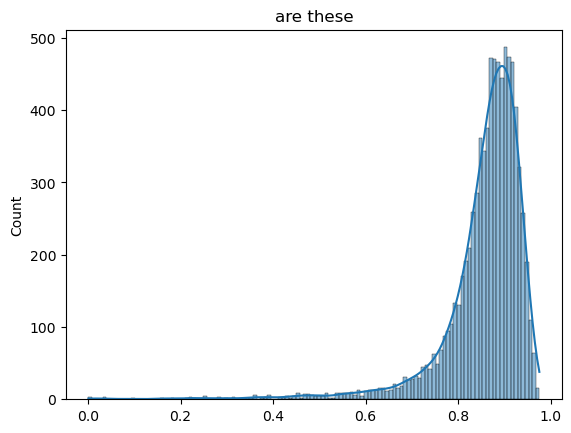

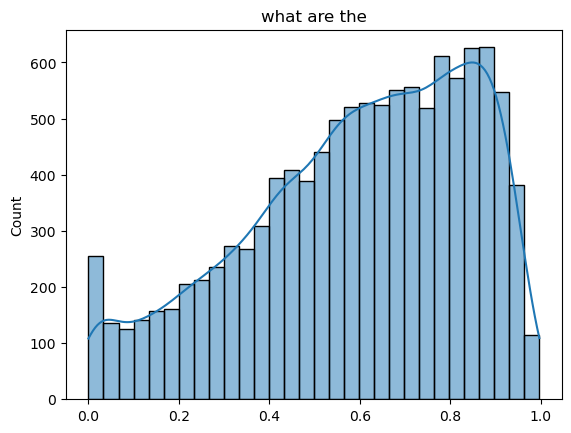

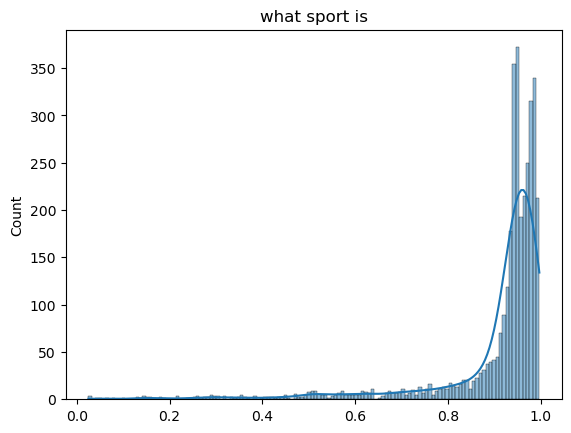

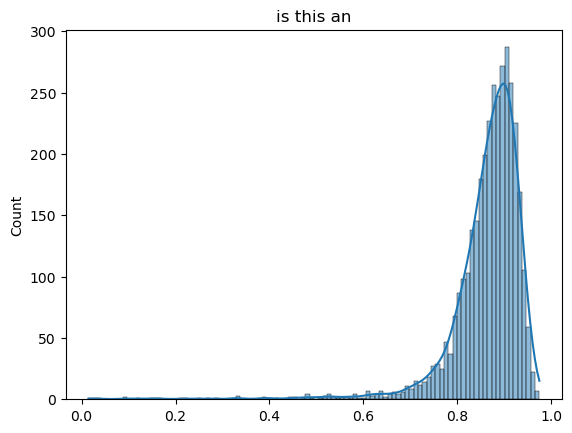

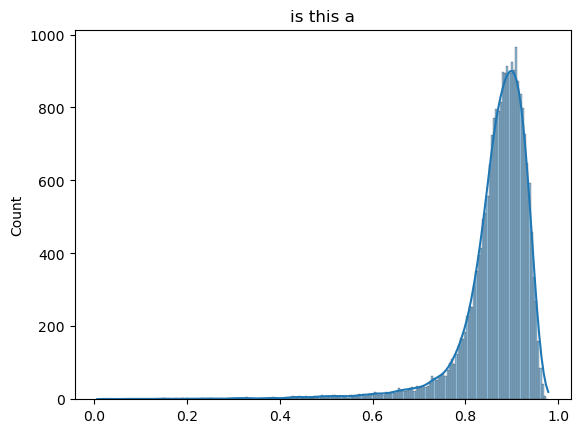

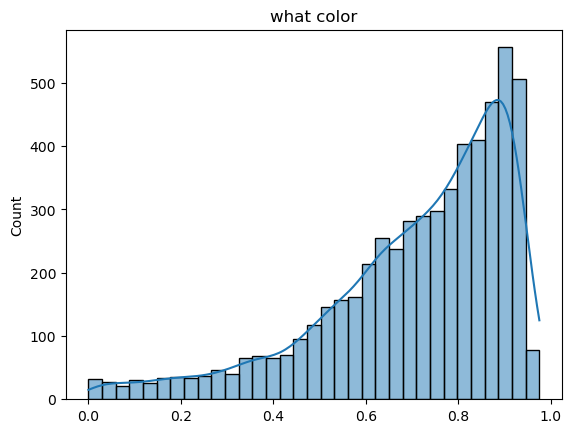

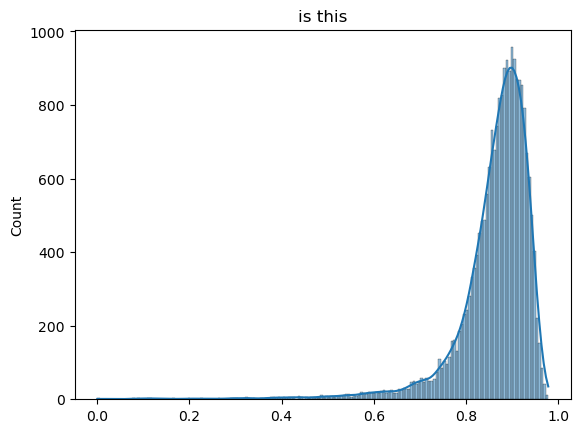

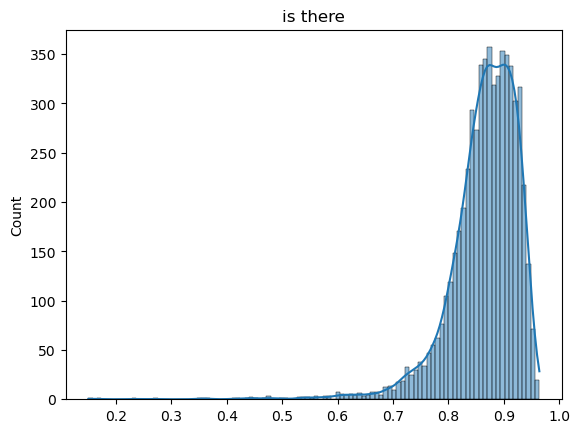

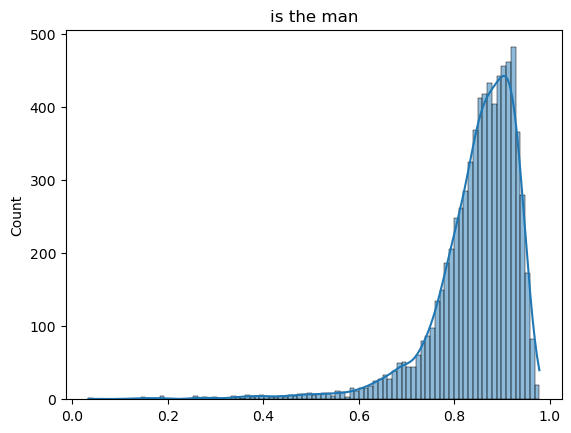

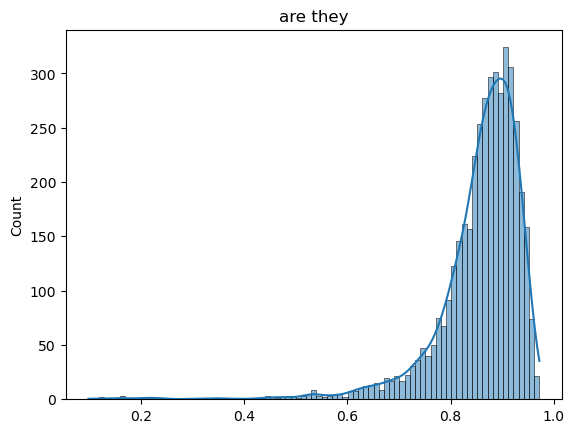

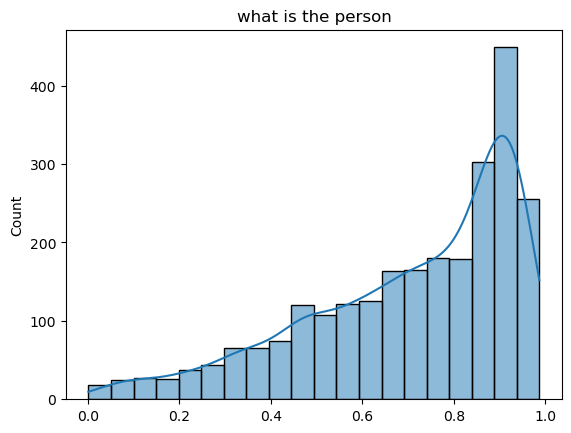

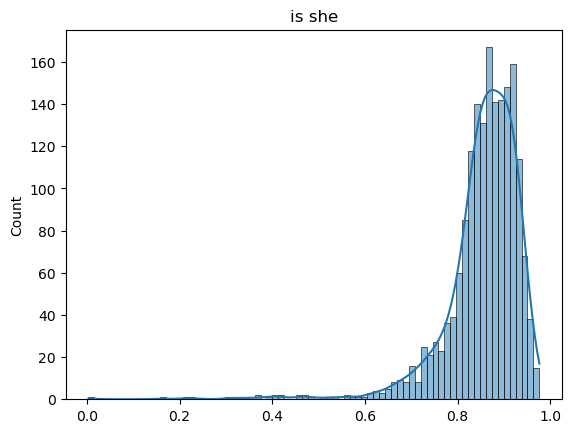

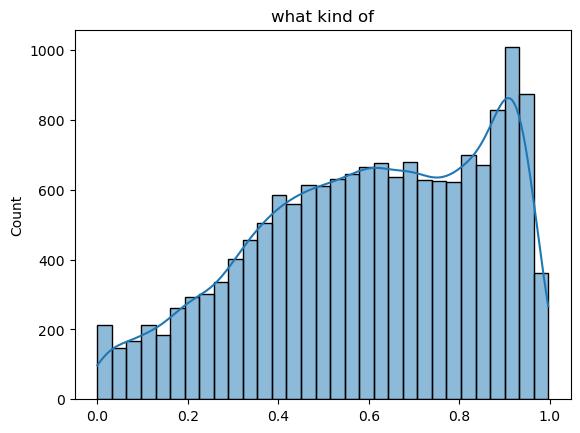

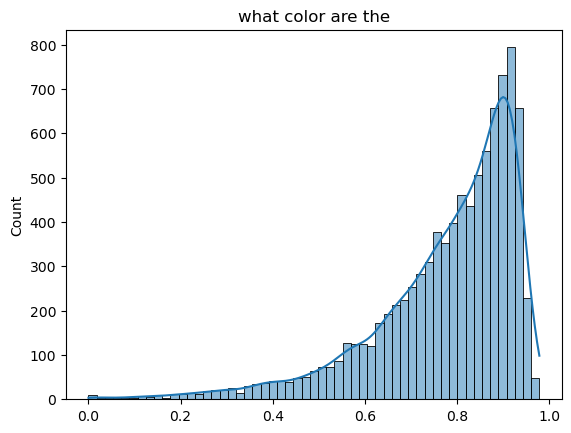

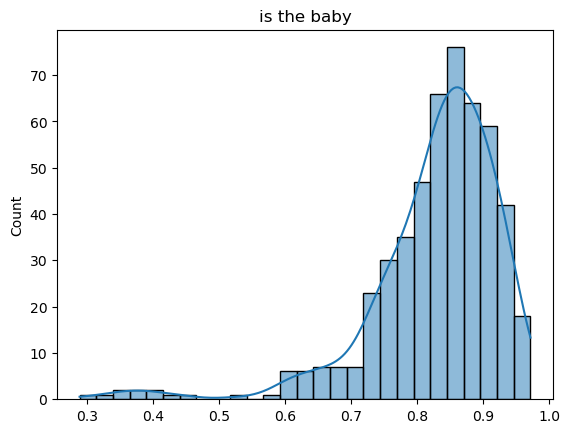

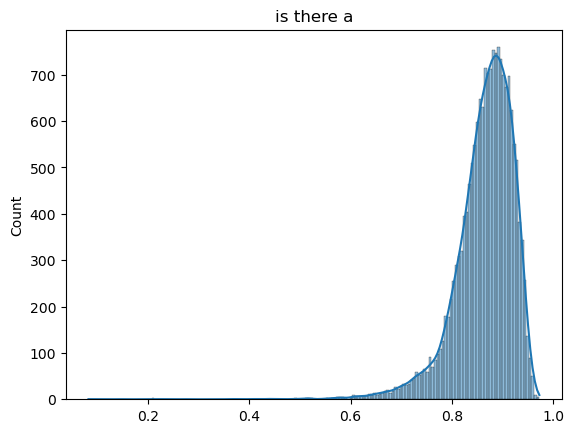

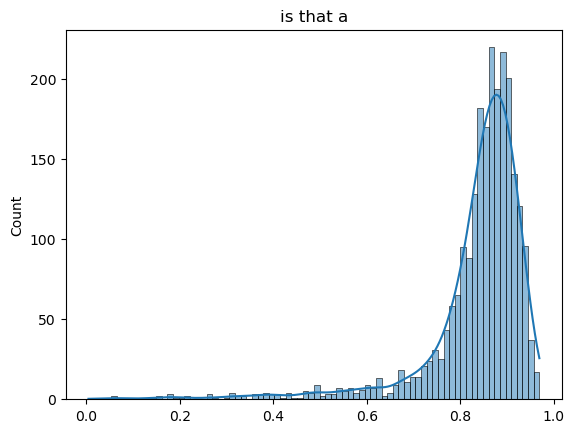

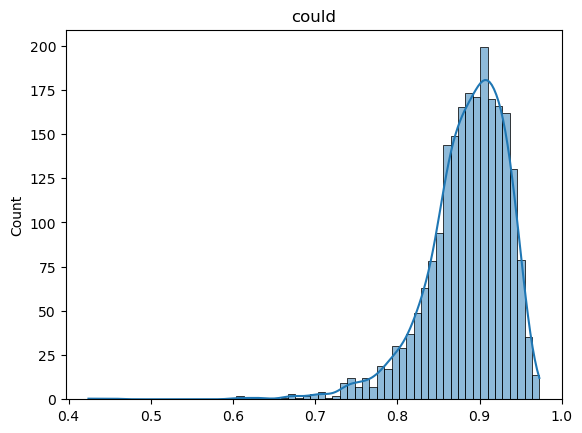

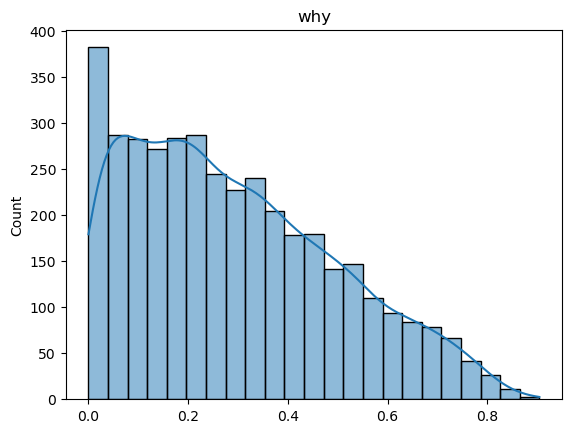

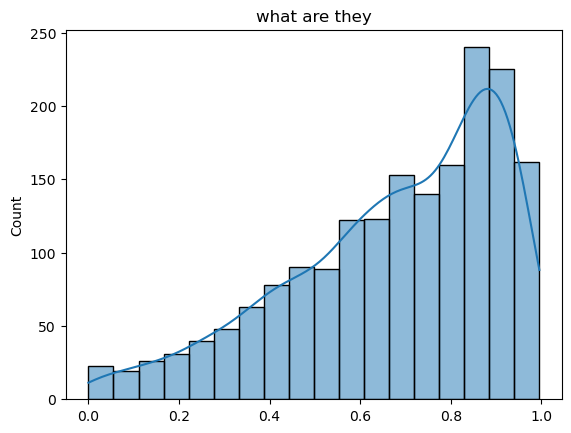

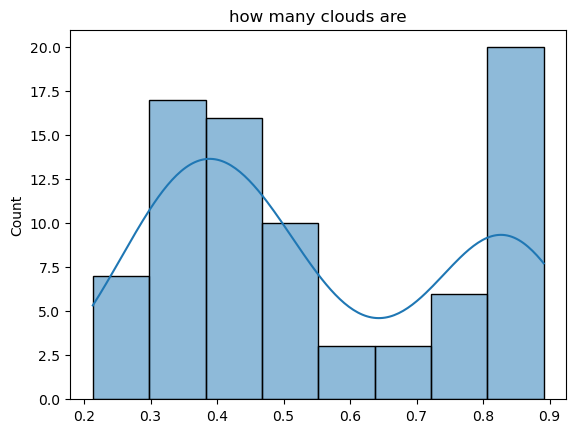

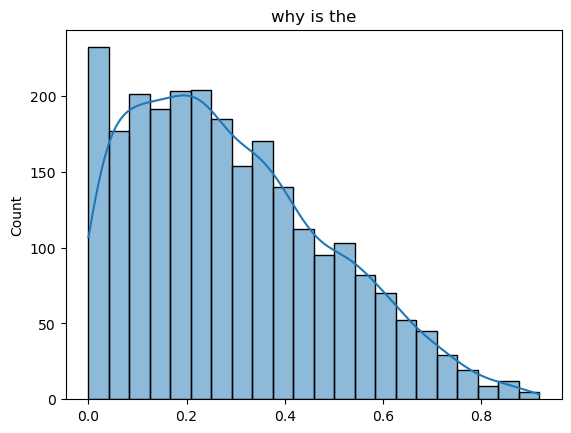

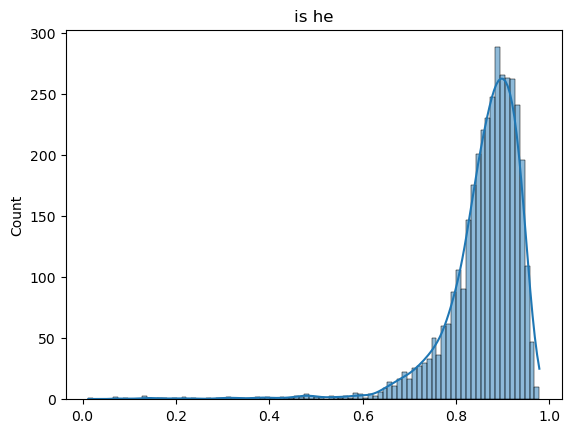

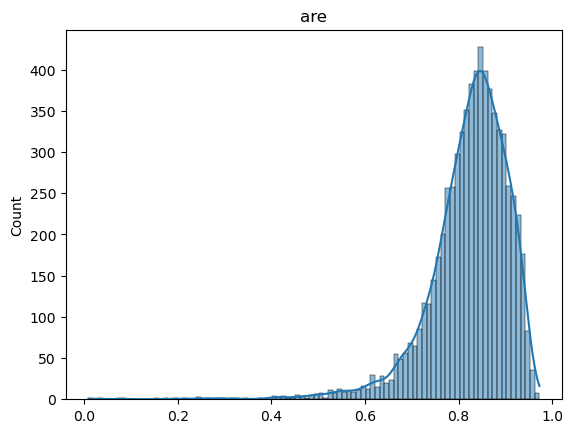

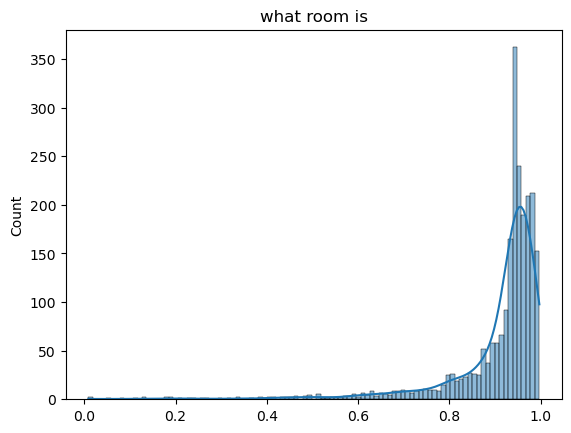

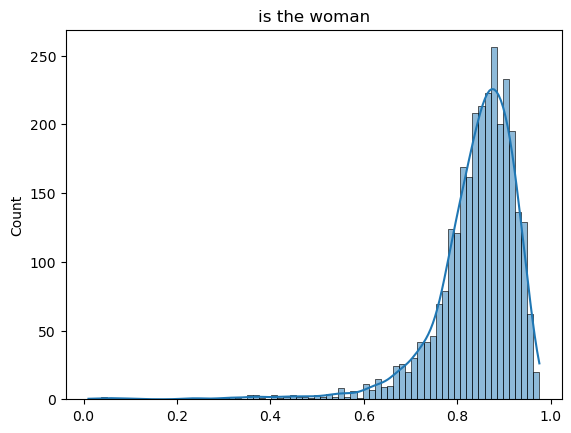

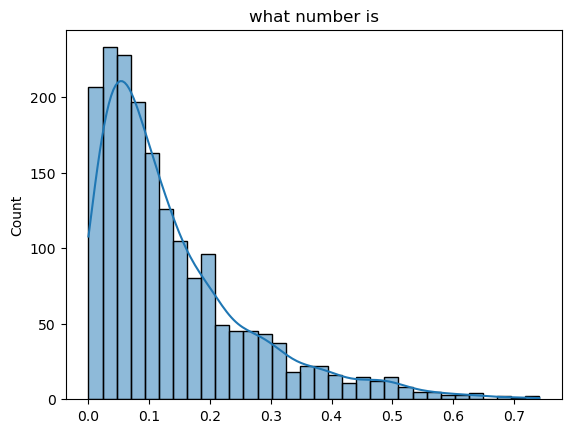

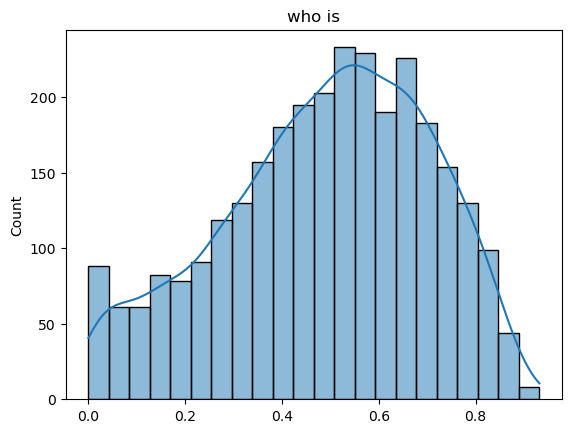

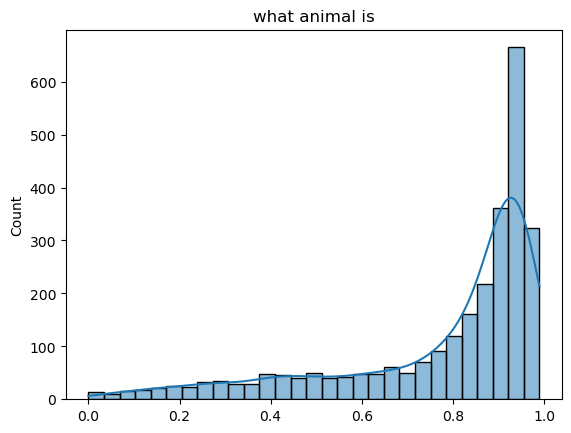

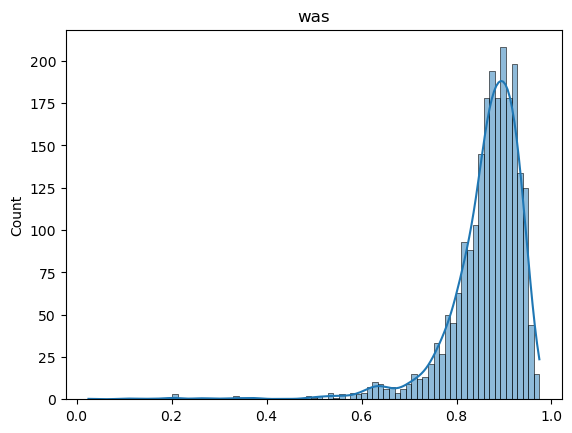

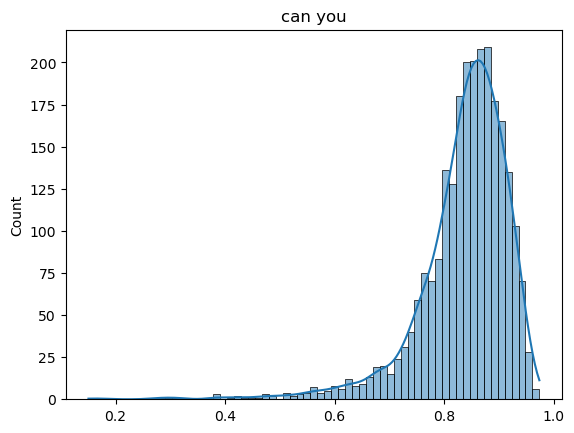

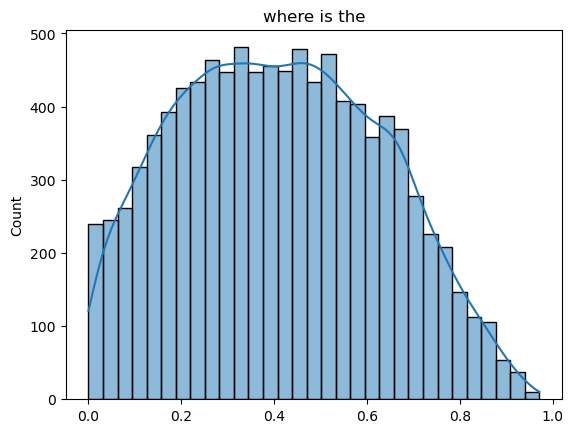

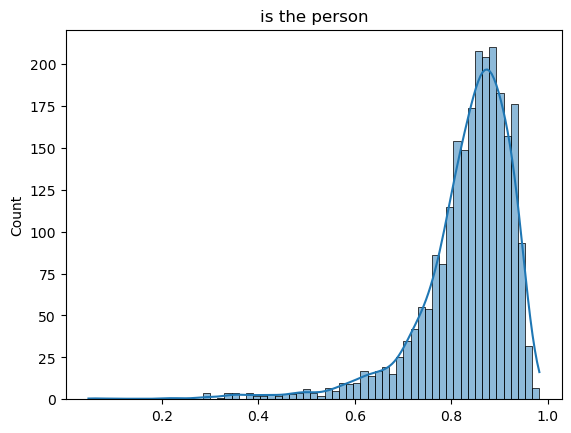

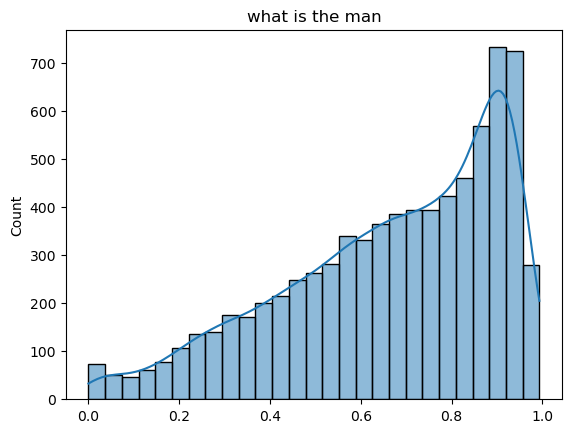

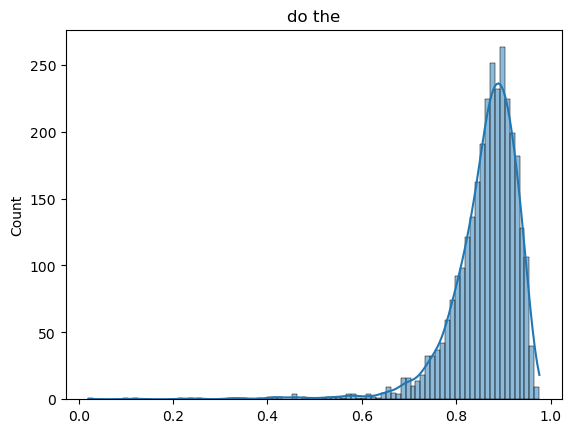

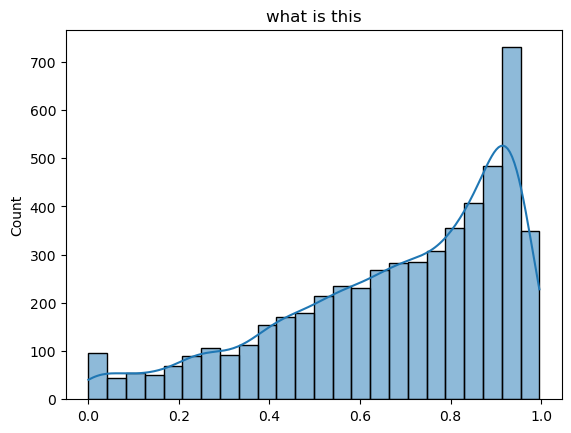

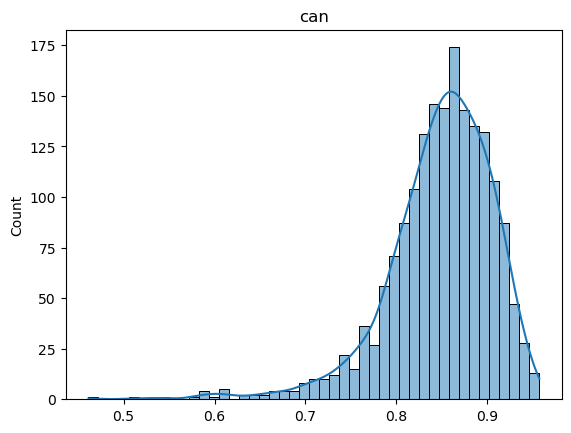

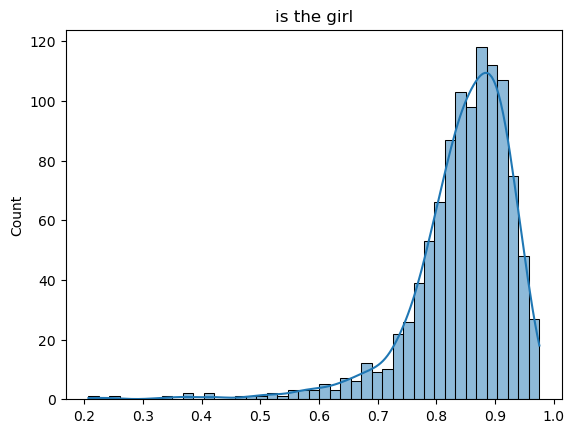

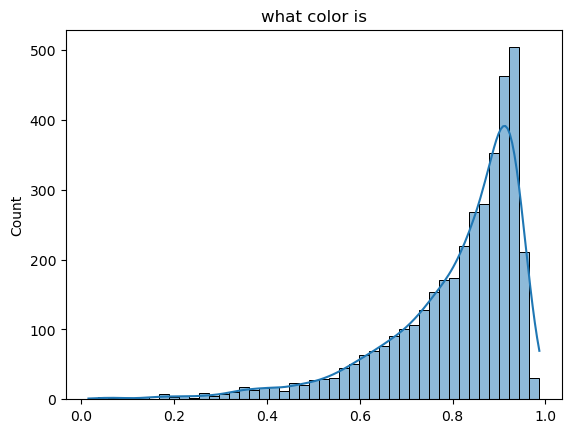

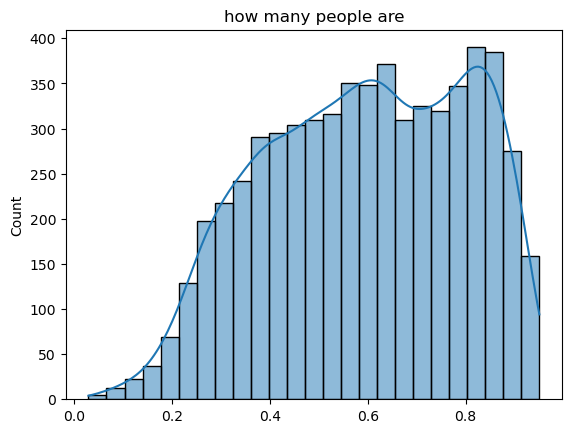

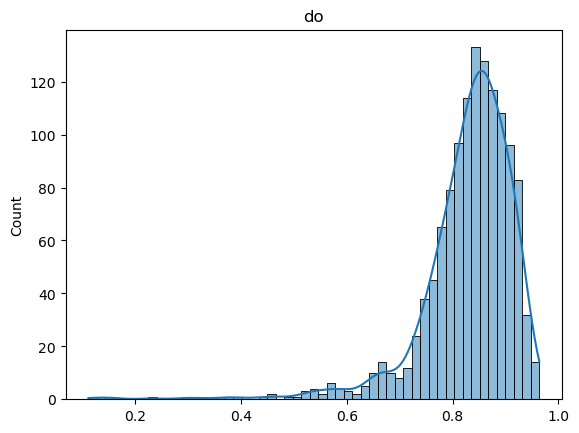

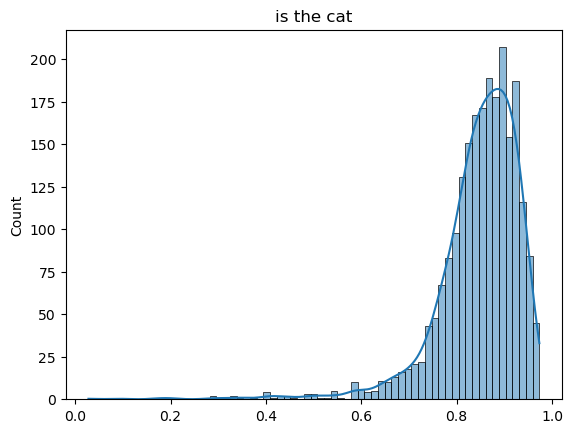

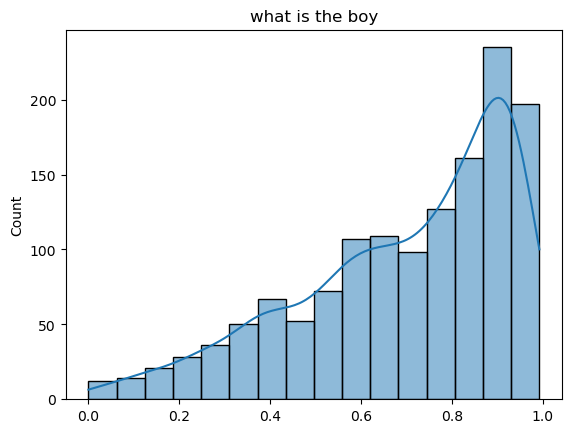

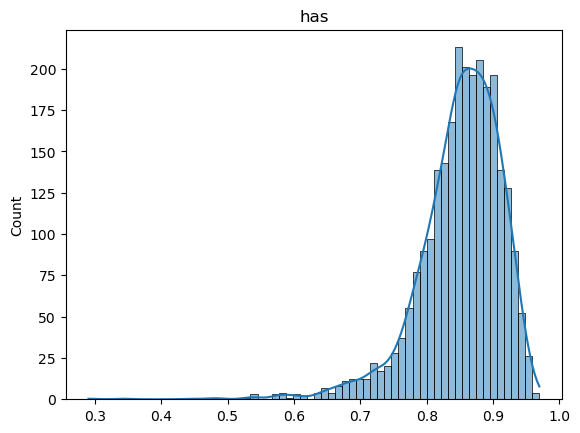

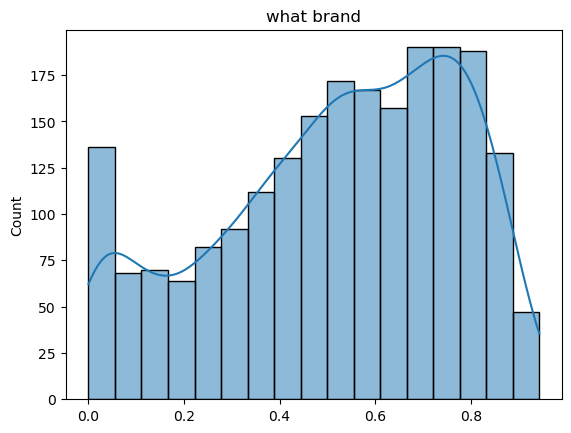

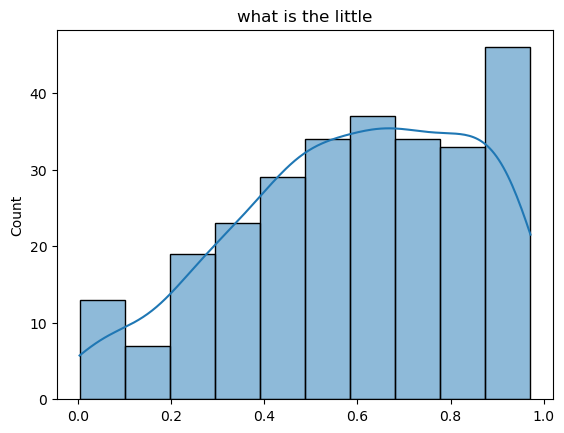

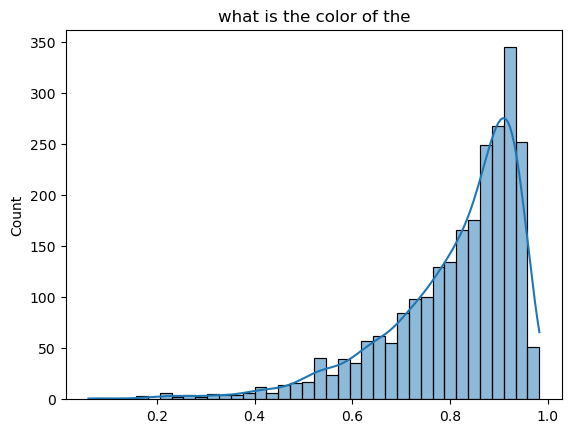

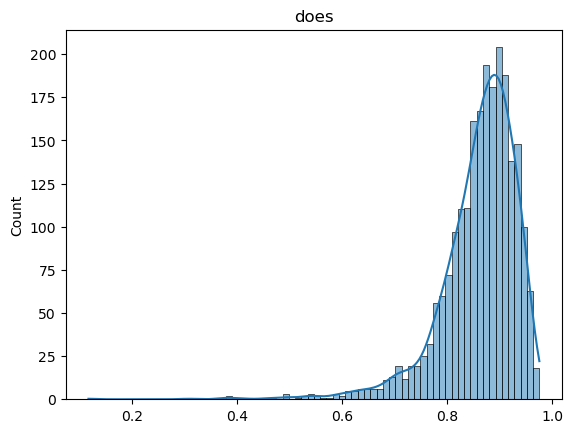

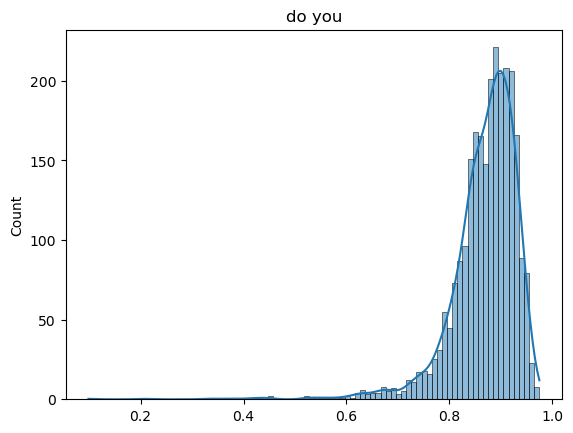

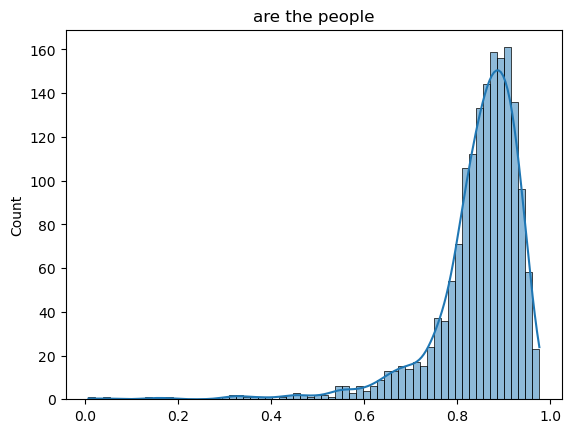

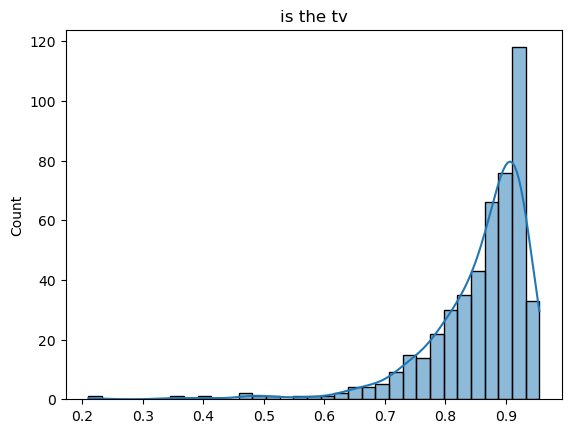

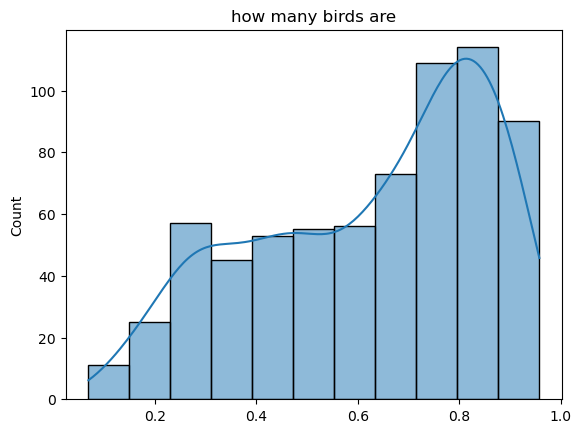

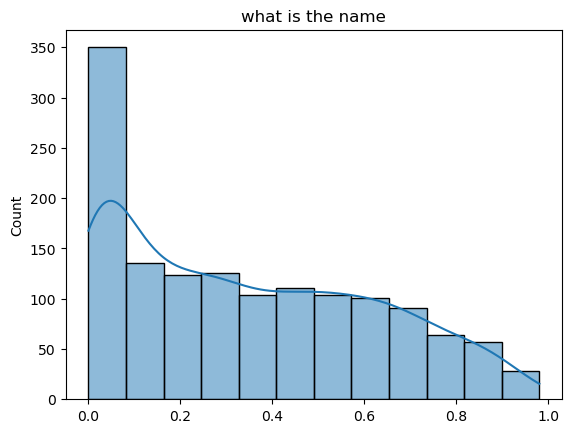

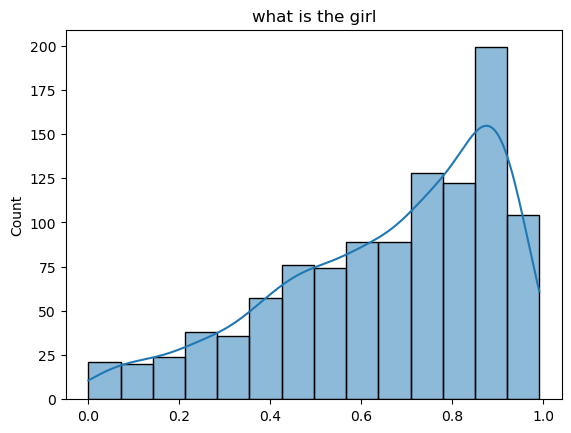

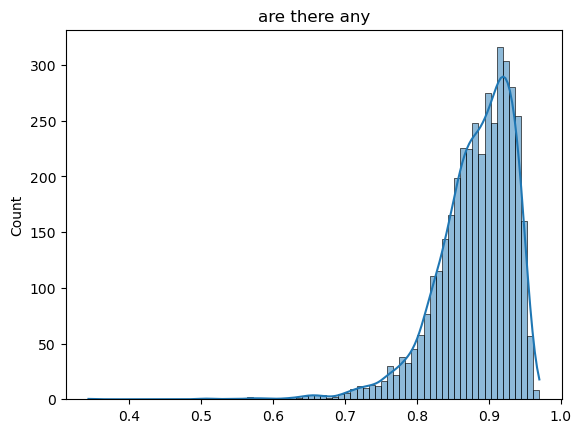

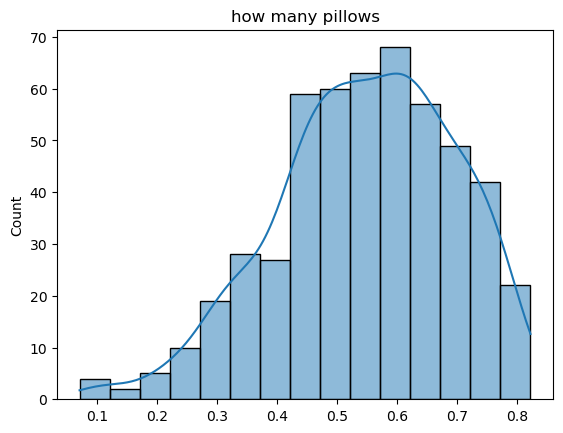

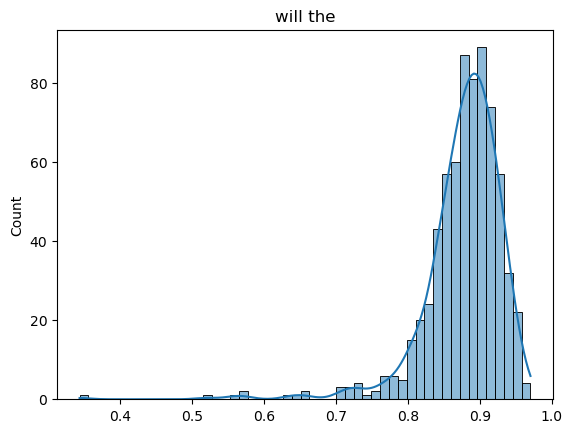

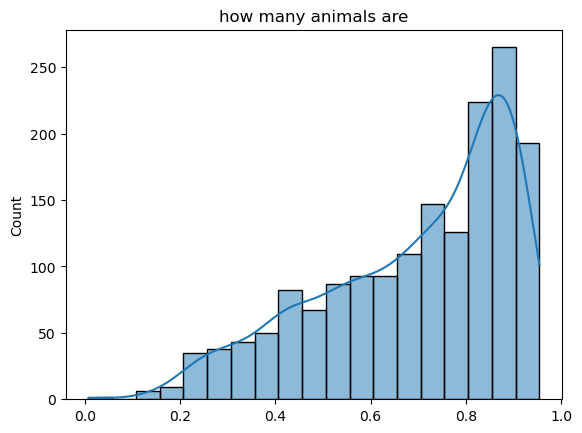

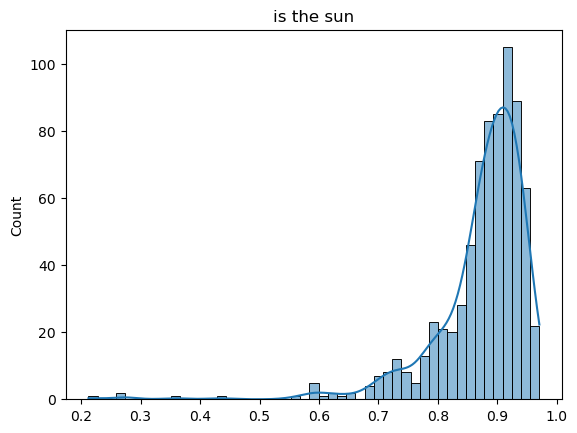

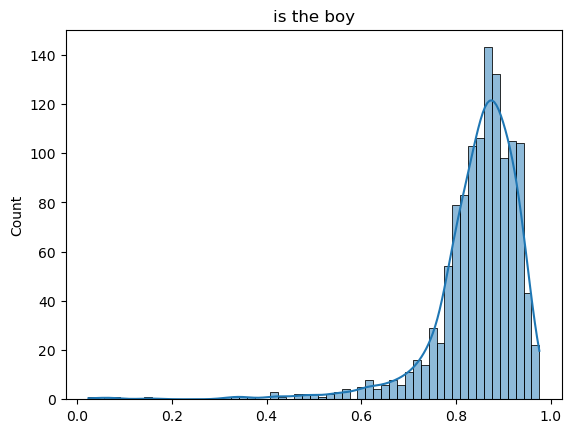

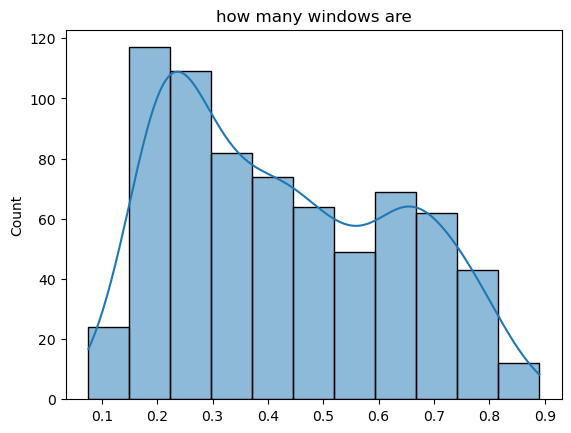

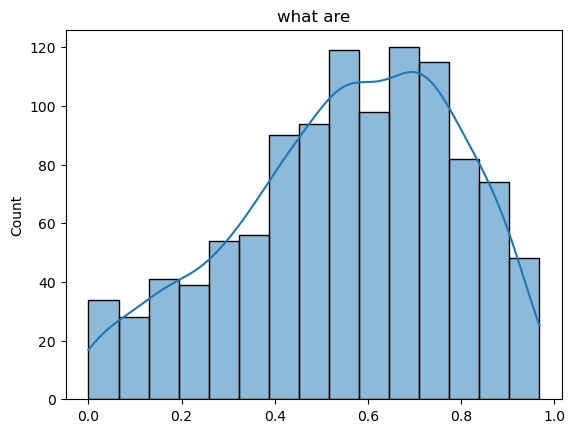

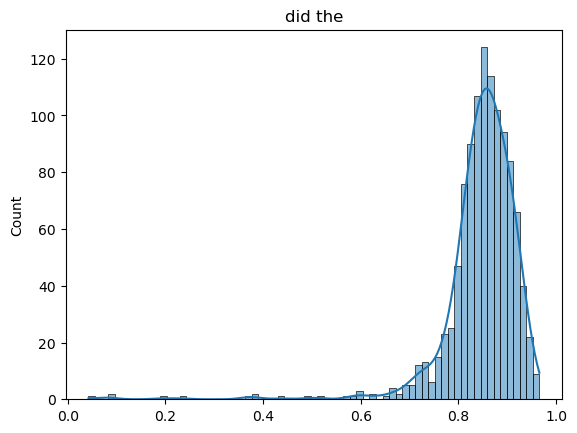

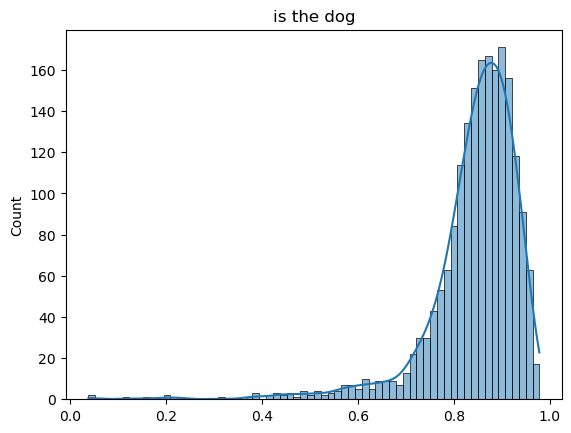

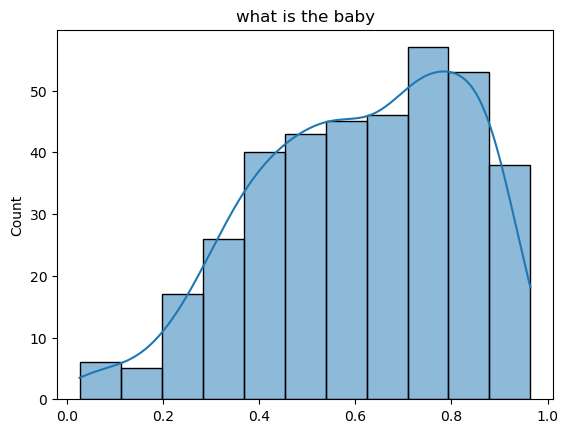

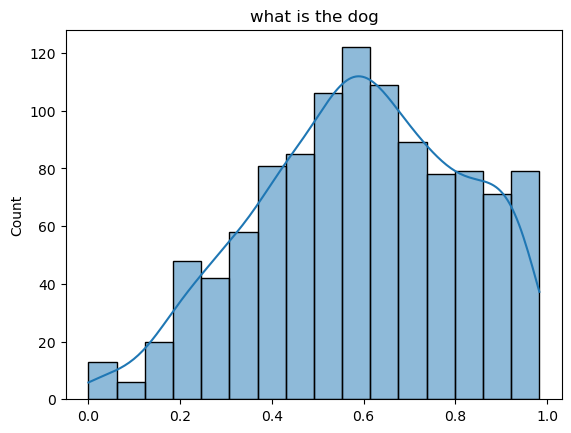

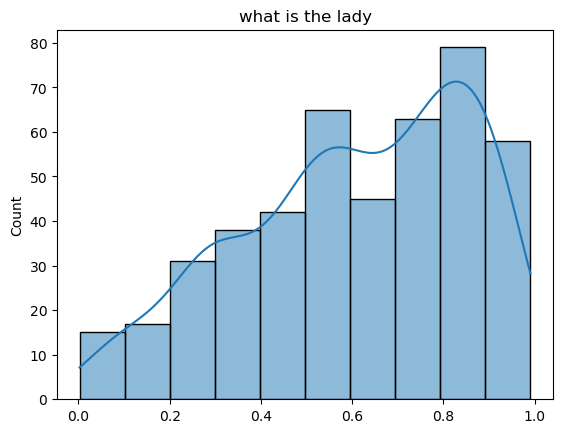

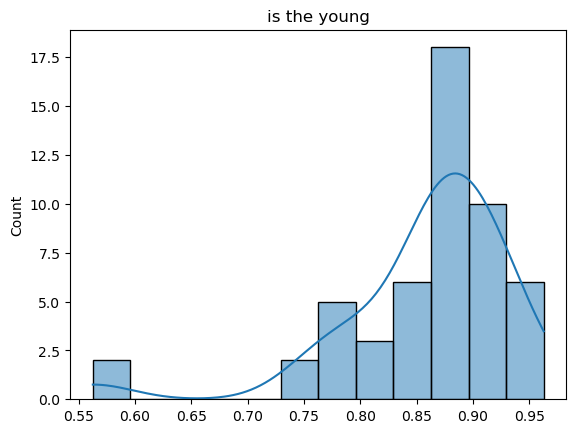

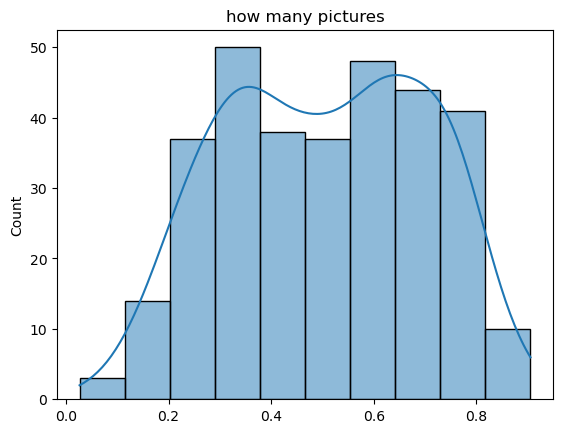

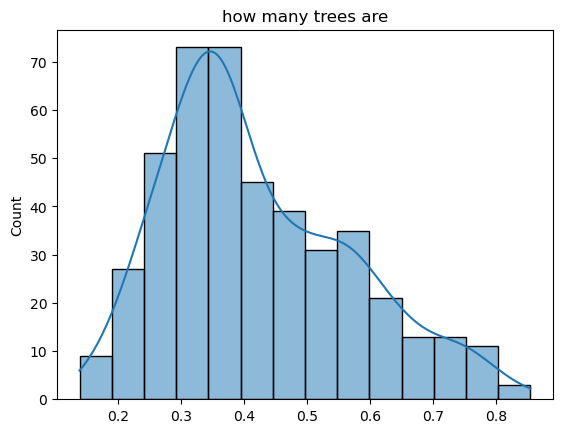

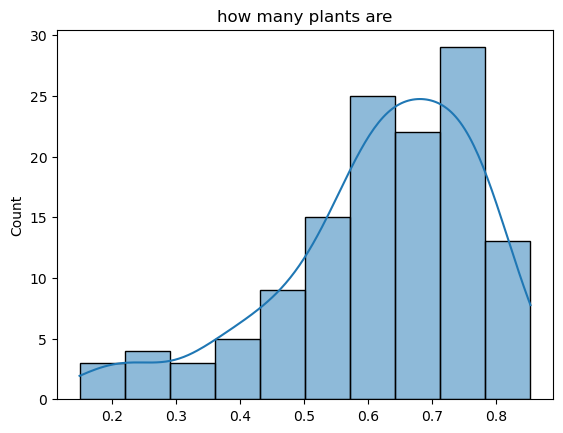

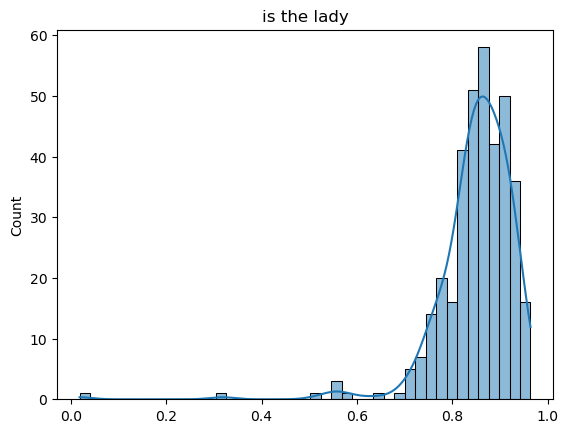

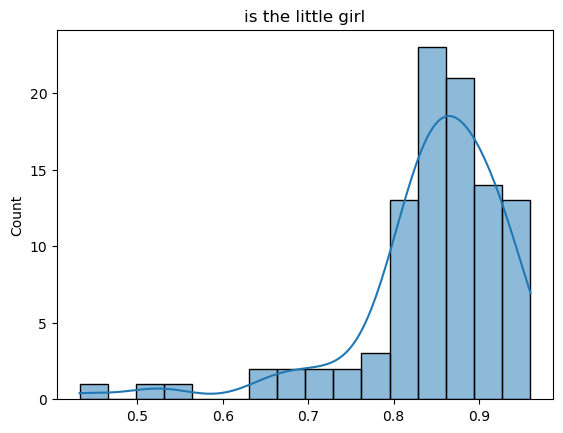

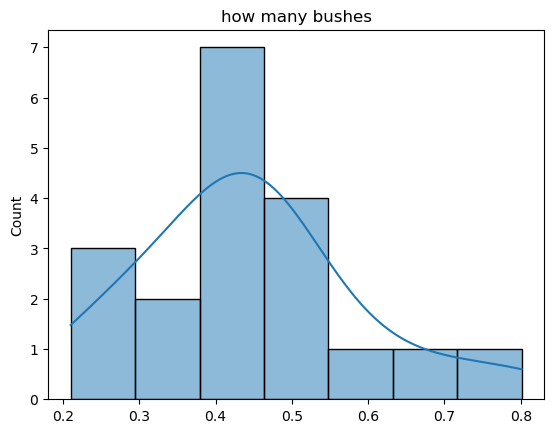

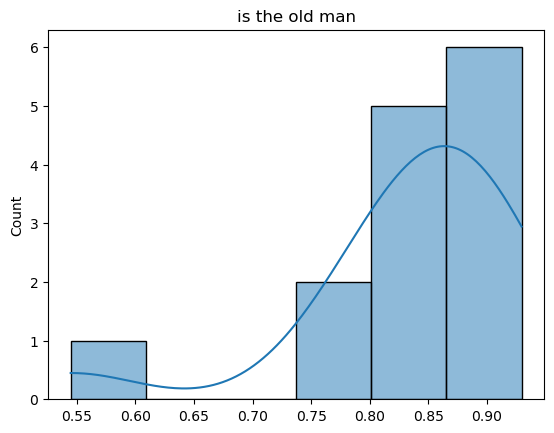

In [68]:
variability_histogram(base_path, sampling_ids=None)
confidence_histogram(base_path, sampling_ids=None)

## normal_near_mode_variability 0.1-0.4

In [ ]:
variability_histogram(base_path, sampling_ids=normal_near_mode_sampling_ids)
confidence_histogram(base_path, sampling_ids=normal_near_mode_sampling_ids)

## beta pvals variability (2,1)

In [ ]:
variability_histogram(base_path, sampling_ids=beta_pvals_sampling_ids)
confidence_histogram(base_path, sampling_ids=beta_pvals_sampling_ids)